### HW1
#### Aviv Zilbershtein 323080556 and Omri Orgad 322523077

In [196]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import numpy as np
import scipy
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBRegressor,XGBClassifier
import pickle

In [207]:
PATH =r"<your_path>"

In [208]:
def load_files(path_folder):
    df_patients_train = []
    for i, filename in enumerate(os.listdir(path_folder)):
        f = os.path.join(path_folder, filename)
        df_patient = pd.read_csv(str(f), sep='|')
        try:
            first_one = df_patient.loc[df_patient["SepsisLabel"] == 1].index[0] + 1 # extracts the first index when the label chnages from 0 to 1
        except IndexError:
            first_one = len(df_patient) # in case the patient is not sick, return the full df of the patient
        df_patient_filtered = df_patient.iloc[0:first_one]
        patient_id_number = str(re.search(r'\d+', filename).group())
        patient_id = 'patient_'+ patient_id_number
        df_patient_filtered["patient id"] = patient_id
        df_patients_train.append(df_patient_filtered)
        # if i==2:
        #     break
    df = pd.concat(df_patients_train)
    return df

In [155]:
def post_analysis(df, model):
    df_copy = df.copy()
    df_no_label = df_copy.drop('SepsisLabel',axis=1)
    predictions = model.predict(df_no_label)
    df_copy['predicted SepsisLabel'] = list(predictions)
    # for every feature
    for feature in list(df_no_label.columns):
    
        plt.figure(figsize=(25,10))
        axis = sns.histplot(x=feature, hue="predicted SepsisLabel", data=df_copy)
        plt.title("Histogram of " + feature, fontsize=24)
        plt.tight_layout()
        plt.setp(axis.get_legend().get_texts(), fontsize='16') 
        plt.xlabel("")
        plt.show()
    

In [3]:
train_df = load_files(PATH + r"/data/train")
train_df.describe()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
count,679693.000000,655783.000000,255949.000000,643779.000000,660079.000000,519145.000000,638116.000000,26117.000000,40816.000000,31080.000000,...,48027.000000,4791.000000,44519.000000,754817.000000,754817.000000,461114.000000,461114.000000,754817.000000,754817.000000,754817.000000
mean,84.558897,97.196002,36.972567,123.550546,82.335320,63.816631,18.723912,33.052648,-0.771343,24.082228,...,11.408545,284.373763,196.824518,62.033249,0.555015,0.493574,0.506426,-54.724323,26.104538,0.001875
std,17.344198,2.944657,0.770627,23.130050,16.282437,13.895251,5.087824,8.003771,4.288986,4.373755,...,7.386384,151.677491,103.655433,16.409864,0.496964,0.499959,0.499959,168.419139,26.971131,0.043256
min,20.000000,20.000000,20.900000,20.000000,20.000000,20.000000,1.000000,10.000000,-32.000000,0.000000,...,0.100000,35.000000,2.000000,15.000000,0.000000,0.000000,0.000000,-5366.860000,1.000000,0.000000
25%,72.000000,96.000000,36.500000,107.000000,71.000000,54.000000,15.000000,28.000000,-3.000000,22.000000,...,7.600000,181.000000,128.000000,51.640000,0.000000,0.000000,0.000000,-45.450000,11.000000,0.000000
50%,83.000000,98.000000,37.000000,121.000000,80.000000,62.000000,18.000000,33.000000,0.000000,24.000000,...,10.300000,248.000000,182.000000,64.000000,1.000000,0.000000,1.000000,-5.980000,21.000000,0.000000
75%,95.500000,99.500000,37.500000,138.000000,92.000000,72.000000,21.500000,38.000000,1.000000,26.000000,...,13.700000,348.000000,244.000000,74.000000,1.000000,1.000000,1.000000,-0.040000,34.000000,0.000000
max,280.000000,100.000000,50.000000,299.000000,300.000000,300.000000,100.000000,100.000000,49.500000,55.000000,...,440.000000,1760.000000,2322.000000,100.000000,1.000000,1.000000,1.000000,17.340000,336.000000,1.000000


In [4]:
train_df.isna().sum()

HR                   75124
O2Sat                99034
Temp                498868
SBP                 111038
MAP                  94738
DBP                 235672
Resp                116701
EtCO2               728700
BaseExcess          714001
HCO3                723737
FiO2                693249
pH                  702705
PaCO2               713216
SaO2                728760
AST                 742970
BUN                 703383
Alkalinephos        743096
Calcium             710957
Chloride            721044
Creatinine          709158
Bilirubin_direct    753423
Glucose             625368
Lactate             735127
Magnesium           707622
Phosphate           725052
Potassium           684809
Bilirubin_total     743886
TroponinI           747540
Hct                 688080
Hgb                 699294
PTT                 733039
WBC                 706790
Fibrinogen          750026
Platelets           710298
Age                      0
Gender                   0
Unit1               293703
U

In [5]:
train_df_aggregated = train_df.groupby("patient id").mean()
train_df_aggregated.loc[train_df_aggregated["SepsisLabel"] > 0, "SepsisLabel"] = 1
train_df_aggregated_not_sepsis = train_df_aggregated[train_df_aggregated["SepsisLabel"] == 0]
train_df_aggregated_sepsis = train_df_aggregated[train_df_aggregated["SepsisLabel"] == 1]


In [69]:
train_df_aggregated.isnull().sum()


HR                    178
O2Sat                 191
Temp                  353
SBP                   328
MAP                   223
DBP                  3756
Resp                  215
EtCO2               18508
BaseExcess          13563
HCO3                10221
FiO2                11371
pH                  10823
PaCO2               11116
SaO2                13676
AST                 13130
BUN                  1278
Alkalinephos        13232
Calcium              2956
Chloride             9626
Creatinine           1303
Bilirubin_direct    19040
Glucose              1028
Lactate             14020
Magnesium            2727
Phosphate            6264
Potassium            1194
Bilirubin_total     13161
TroponinI           16521
Hct                  1404
Hgb                  1481
PTT                 10231
WBC                  1565
Fibrinogen          17819
Platelets            1550
Age                     0
Gender                  0
Unit1                7686
Unit2                7686
HospAdmTime 

In [ ]:
fig = plt.figure(figsize=(30, 30), dpi=80)
sns.heatmap(train_df_aggregated_sepsis.corr(), annot=True, cmap='coolwarm')
plt.title("Heatmap of selected features of patients with sepsis")
# show the heatmap
#plt.savefig(PATH+r'\heatmap_sepsis.png', bbox_inches='tight')
plt.show()

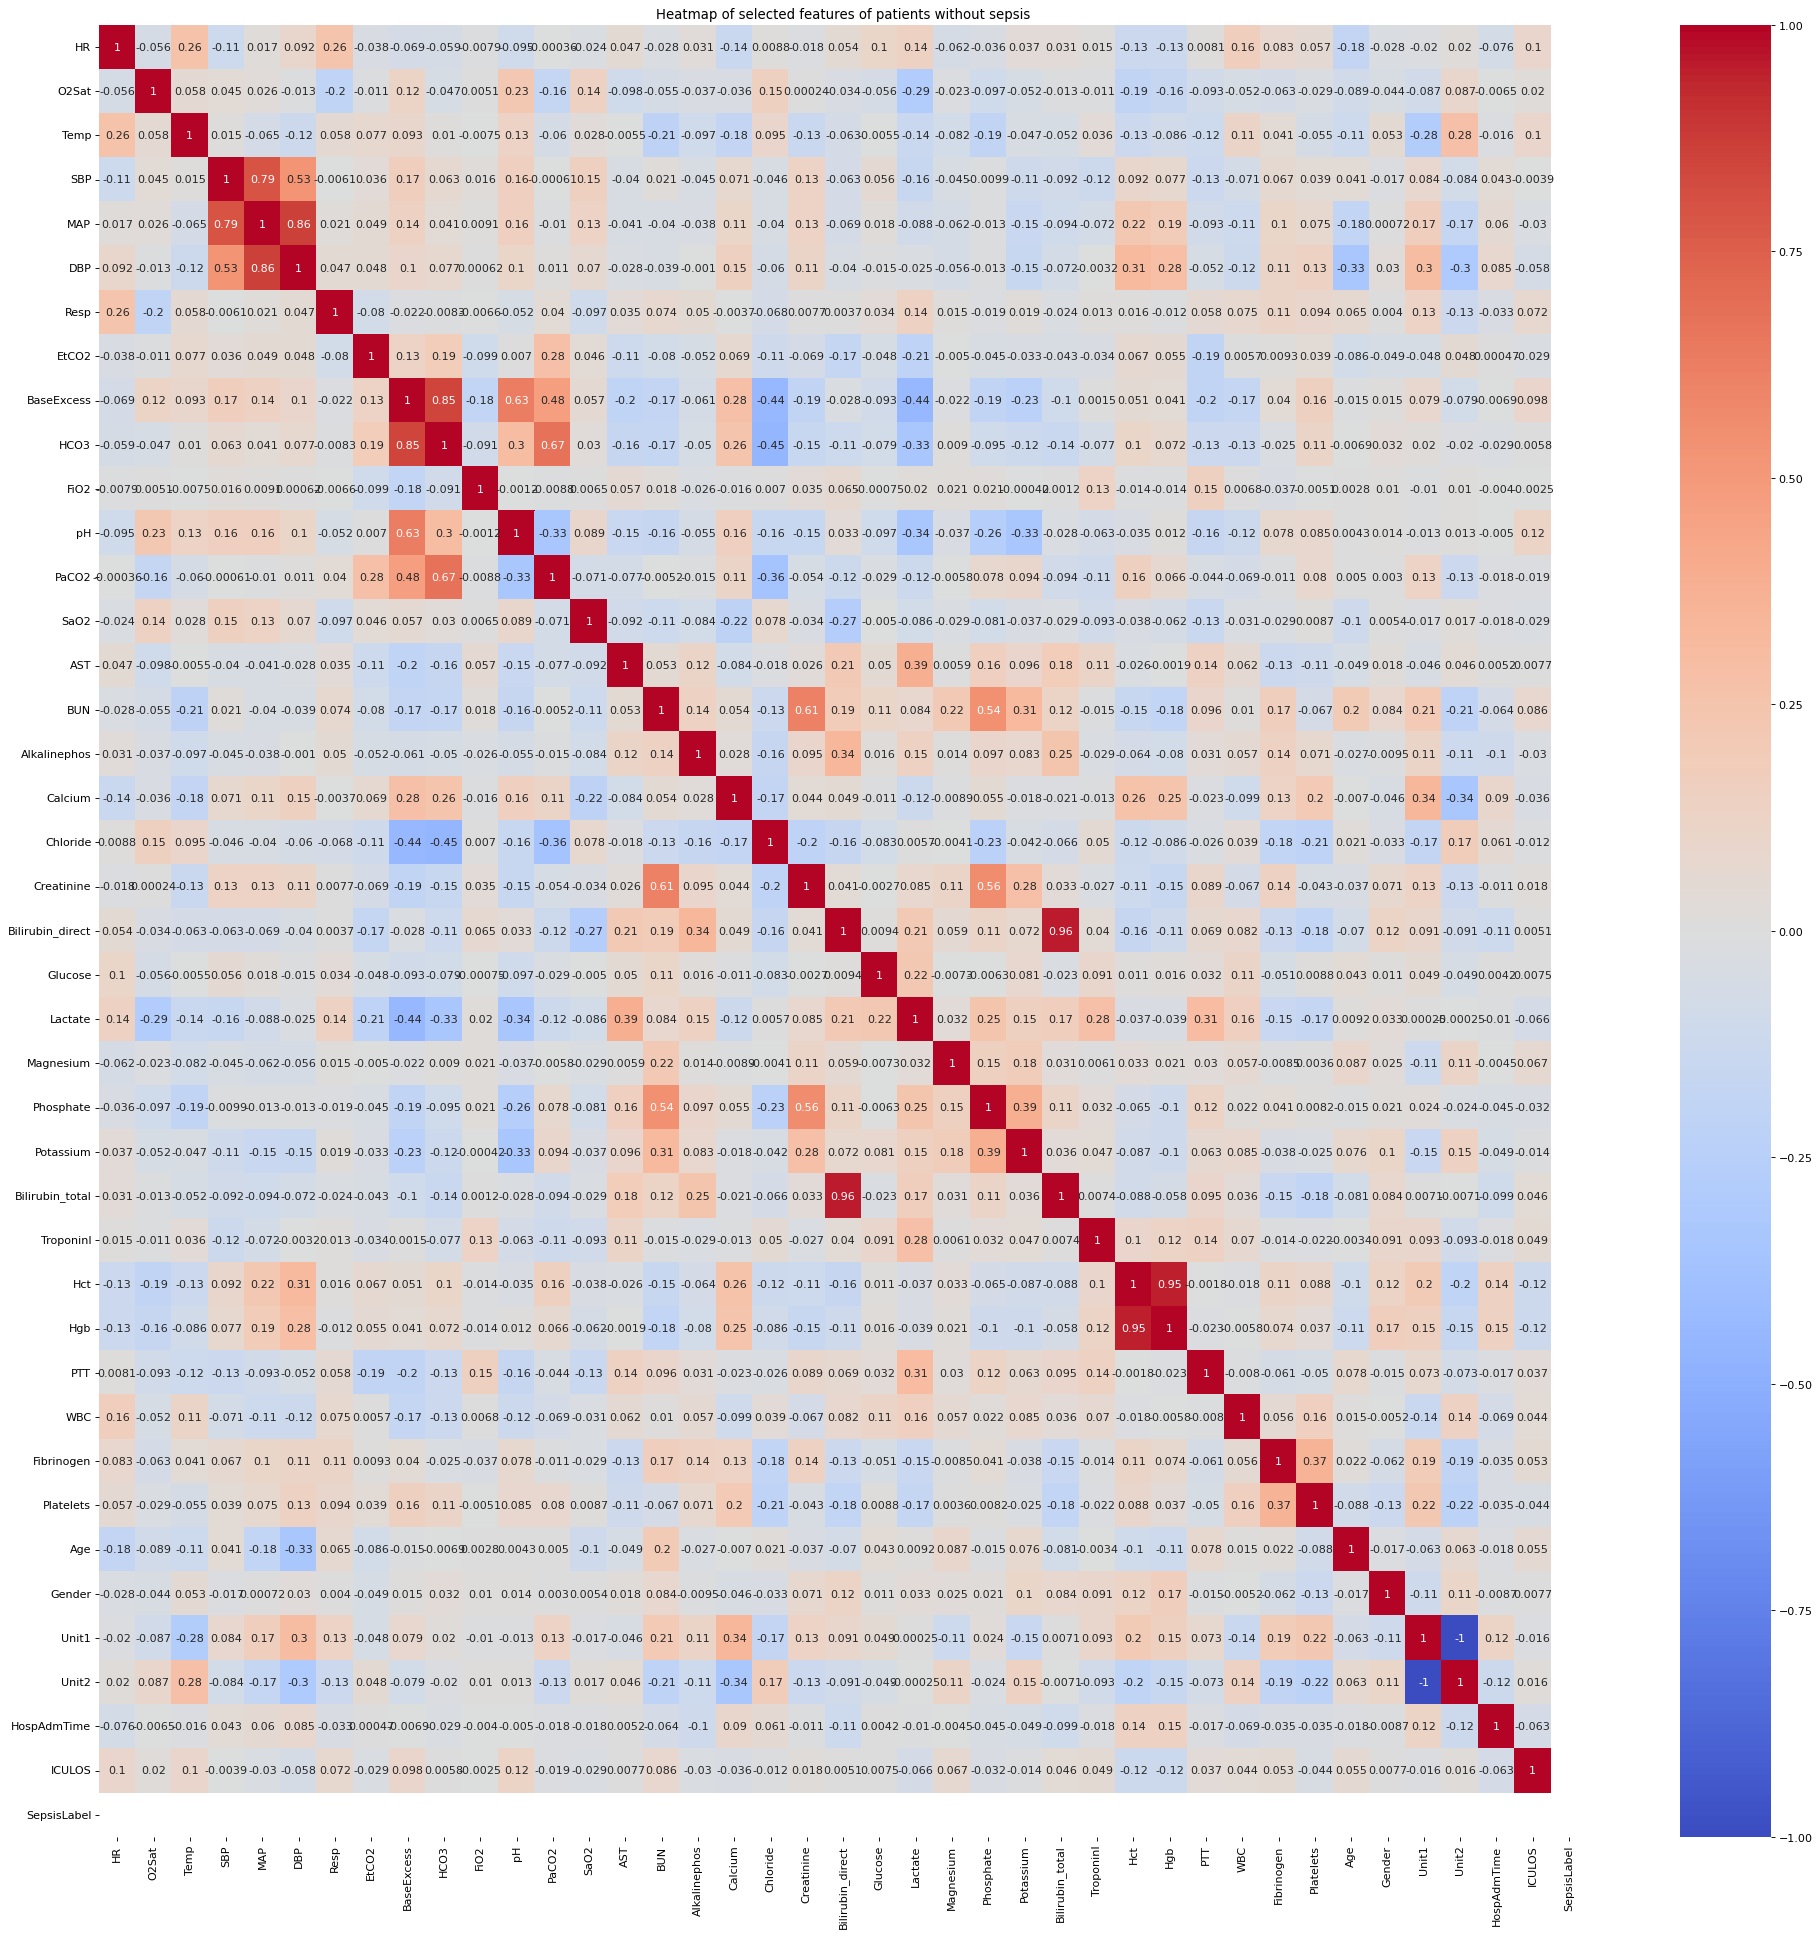

In [201]:
fig = plt.figure(figsize=(30, 30), dpi=80)
sns.heatmap(train_df_aggregated_not_sepsis.corr(), annot=True, cmap='coolwarm')
plt.title("Heatmap of selected features of patients without sepsis")
# show the heatmap
#plt.savefig(PATH+r'\heatmap_not_sepsis.png', bbox_inches='tight')
plt.show()

In [183]:
train_df_aggregated_copy = train_df_aggregated.copy()
train_df_aggregated_copy = train_df_aggregated_copy.drop(['Bilirubin_direct', 'Hct','Unit1', 'Unit2','HospAdmTime'], axis=1)
convert_to_bin = ['EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 
                  'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 
                  'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
                  'Bilirubin_total', 'TroponinI', 'Hgb', 'PTT', 'WBC',
                  'Fibrinogen', 'Platelets',
                 ]
convert_to_mean = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp']
for feature in convert_to_bin:
    train_df_aggregated_copy['Bin_'+feature]= train_df_aggregated_copy[feature].apply(lambda x: 0 if pd.isna(x) else 1)
train_df_aggregated_copy = train_df_aggregated_copy.drop(convert_to_bin, axis=1)
for feature in convert_to_mean:
    train_df_aggregated_copy[feature] = train_df_aggregated_copy[feature].fillna(train_df_aggregated_copy[feature].mean())
train_df_aggregated_copy.isnull().sum()

HR                     0
O2Sat                  0
Temp                   0
SBP                    0
MAP                    0
DBP                    0
Resp                   0
Age                    0
Gender                 0
ICULOS                 0
SepsisLabel            0
Bin_EtCO2              0
Bin_BaseExcess         0
Bin_HCO3               0
Bin_FiO2               0
Bin_pH                 0
Bin_PaCO2              0
Bin_SaO2               0
Bin_AST                0
Bin_BUN                0
Bin_Alkalinephos       0
Bin_Calcium            0
Bin_Chloride           0
Bin_Creatinine         0
Bin_Glucose            0
Bin_Lactate            0
Bin_Magnesium          0
Bin_Phosphate          0
Bin_Potassium          0
Bin_Bilirubin_total    0
Bin_TroponinI          0
Bin_Hgb                0
Bin_PTT                0
Bin_WBC                0
Bin_Fibrinogen         0
Bin_Platelets          0
dtype: int64

### Statistical tests for finding most significant features

In [184]:
def proportion_test(col1, col2, bonf_correction):
    n1 = col1.size
    n2 = col2.size
    x1 = col1.sum()
    x2 = col2.sum()
    p = (x1 + x2)/(n1+n2)
    p1 = x1/n1
    p2 = x2/n2
    std = (p*(1-p)*(1/n1+1/n2))**0.5
    z = (p1-p2)/std
    pval = 1-scipy.stats.norm.cdf(z)
    pval = pval * bonf_correction #Correction for multiple comparisons\
    if pval > 1.0:
        pval = 1.0
    print(f"pval is {pval}")
    return pval

In [185]:
pvals = []
bin_len = len(convert_to_bin)
significant = []
non_significant = []
alpha = 0.05
for f in convert_to_bin:
    feature = 'Bin_'+f
    print("-"*20)
    print(feature)
    col1 = train_df_aggregated_copy.loc[train_df_aggregated_copy["SepsisLabel"] == 1][feature]
    col2 = train_df_aggregated_copy.loc[train_df_aggregated_copy["SepsisLabel"] == 0][feature]
    pval = proportion_test(col1, col2, bin_len)
    pvals.append(pval)
    if pval < alpha:
        significant.append(feature)
    else:
        non_significant.append(feature)
    print("-"*20)

print("significant variables:")
print(significant)
print("non-significant variables:")
print(non_significant)

--------------------
Bin_EtCO2
pval is 3.608224830031759e-13
--------------------
--------------------
Bin_BaseExcess
pval is 0.0
--------------------
--------------------
Bin_HCO3
pval is 1.0
--------------------
--------------------
Bin_FiO2
pval is 0.0
--------------------
--------------------
Bin_pH
pval is 0.0
--------------------
--------------------
Bin_PaCO2
pval is 0.0
--------------------
--------------------
Bin_SaO2
pval is 4.834472799863931e-06
--------------------
--------------------
Bin_AST
pval is 0.00016829519825511952
--------------------
--------------------
Bin_BUN
pval is 1.0
--------------------
--------------------
Bin_Alkalinephos
pval is 0.0004198673876909531
--------------------
--------------------
Bin_Calcium
pval is 1.0
--------------------
--------------------
Bin_Chloride
pval is 1.0
--------------------
--------------------
Bin_Creatinine
pval is 1.0
--------------------
--------------------
Bin_Glucose
pval is 1.0
--------------------
-----------------

In [187]:
mean_lean = len(convert_to_mean)
significant = []
non_significant = []
alpha = 0.05
for feature in convert_to_mean:
    print("-"*20)
    col1 = train_df_aggregated_copy.loc[train_df_aggregated_copy["SepsisLabel"] == 1][feature]
    col2 = train_df_aggregated_copy.loc[train_df_aggregated_copy["SepsisLabel"] == 0][feature]
    pval = scipy.stats.ttest_ind(col1, col2, equal_var=False).pvalue
    pval = mean_lean * pval #Bernoulli adjusted pvalue
    print(f"the pvalue of {feature} is {pval}")
    print("-"*20)
    if pval < alpha:
        significant.append(feature)
    else:
        non_significant.append(feature)
    print("-"*20)

print("significant variables:")
print(significant)
print("non-significant variables:")
print(non_significant)

--------------------
the pvalue of HR is 1.2360791787589711e-26
--------------------
--------------------
--------------------
the pvalue of O2Sat is 0.540345983679888
--------------------
--------------------
--------------------
the pvalue of Temp is 1.4400236666010344e-15
--------------------
--------------------
--------------------
the pvalue of SBP is 0.0028891394347955656
--------------------
--------------------
--------------------
the pvalue of MAP is 1.6850480814681175e-08
--------------------
--------------------
--------------------
the pvalue of DBP is 5.286956428461154e-06
--------------------
--------------------
--------------------
the pvalue of Resp is 7.070824191539266e-19
--------------------
--------------------
significant variables:
['HR', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp']
non-significant variables:
['O2Sat']


In [182]:
convert_to_mean

['HR', 'Resp']

In [188]:
from sklearn.feature_selection import SelectKBest, chi2
signicifant_features = ['ICULOS','HR', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp','Bin_EtCO2', 'Bin_BaseExcess', 'Bin_FiO2', 'Bin_pH', 'Bin_PaCO2', 'Bin_SaO2', 
                        'Bin_AST', 'Bin_Alkalinephos', 'Bin_Lactate', 'Bin_Bilirubin_total', 'Bin_PTT', 'Bin_Fibrinogen']
y_full = train_df_aggregated_copy['SepsisLabel']
X_full = train_df_aggregated_copy[signicifant_features]
X_new = SelectKBest(chi2, k=10).fit_transform(X_full, y_full)
best_features = list(X_full.columns.values[SelectKBest(chi2, k=10).fit(X_full, y_full).get_support()])
#importance_scores_= SelectKBest(chi2, k=10).scores_[SelectKBest(chi2, k=10).fit(X_full, y_full).get_support()]

# best_features
best_features

['ICULOS',
 'HR',
 'MAP',
 'Resp',
 'Bin_EtCO2',
 'Bin_BaseExcess',
 'Bin_FiO2',
 'Bin_pH',
 'Bin_PaCO2',
 'Bin_Lactate']

### New (filtering features by chi2 test)

In [138]:
best_features.append('SepsisLabel')
train_df_aggregated_filtered_new = train_df_aggregated_copy[best_features]
train_df_aggregated_filtered_new

,ICULOS,HR,MAP,Resp,Bin_EtCO2,Bin_BaseExcess,Bin_FiO2,Bin_pH,Bin_PaCO2,Bin_Lactate,SepsisLabel
patient id,,,,,,,,,,,
patient_0,12.0,60.954545,66.704545,14.236842,0,0,0,0,0,0,0.0
patient_1,14.0,87.875000,87.260870,15.875000,0,1,1,1,1,1,1.0
patient_10,19.0,89.305556,94.444444,17.882353,0,0,0,0,0,0,0.0
patient_100,22.5,63.615385,81.111111,17.272727,0,0,0,0,0,0,0.0
patient_1000,24.0,79.704545,97.093023,16.365854,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
patient_9995,28.5,88.943396,99.000000,16.377778,0,0,0,0,0,0,0.0
patient_9996,21.5,97.025000,115.448718,13.425000,0,0,0,0,0,0,0.0
patient_9997,9.0,78.031250,94.406250,17.875000,0,0,0,0,0,0,0.0


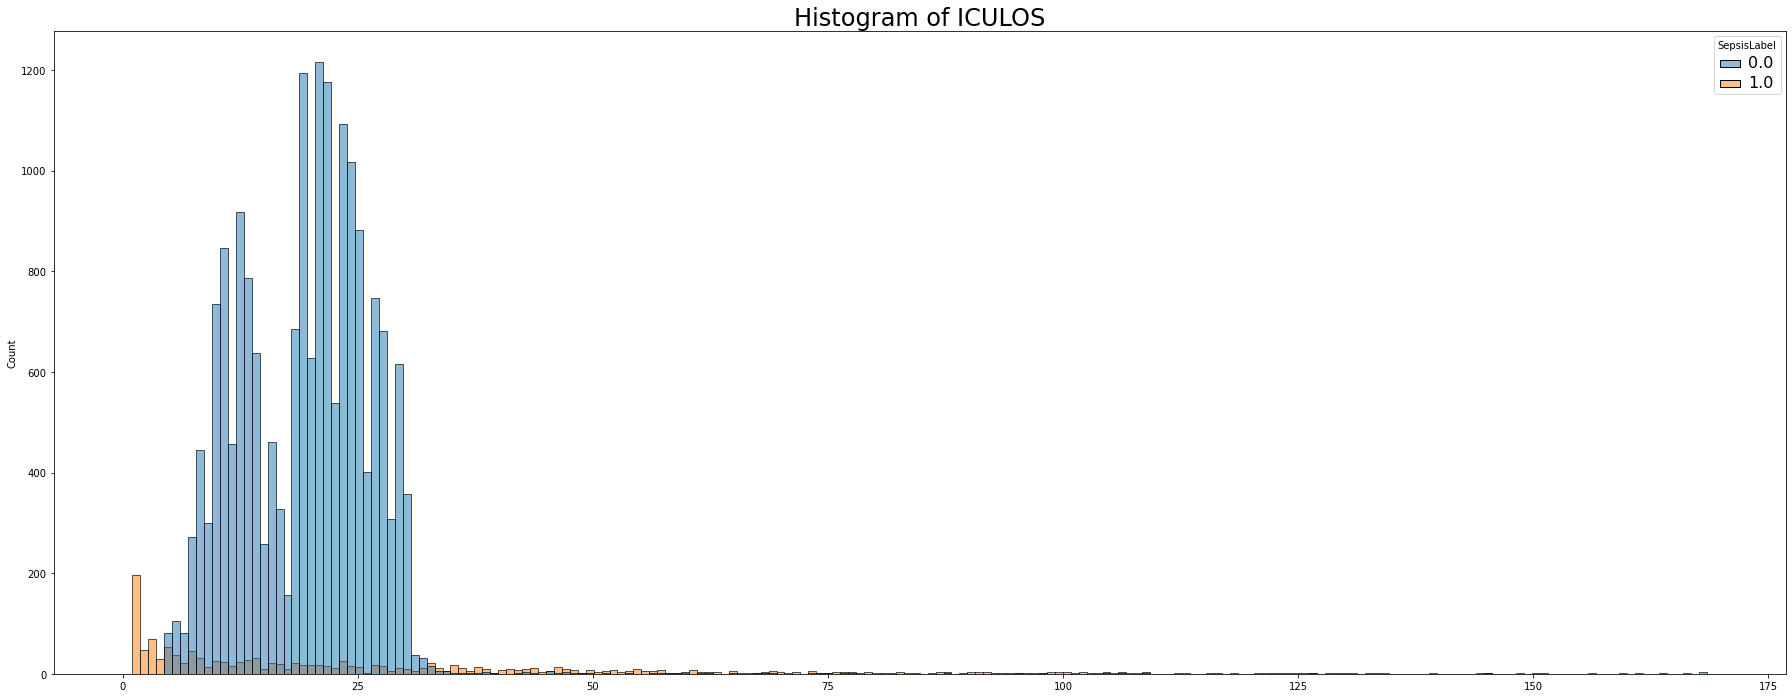

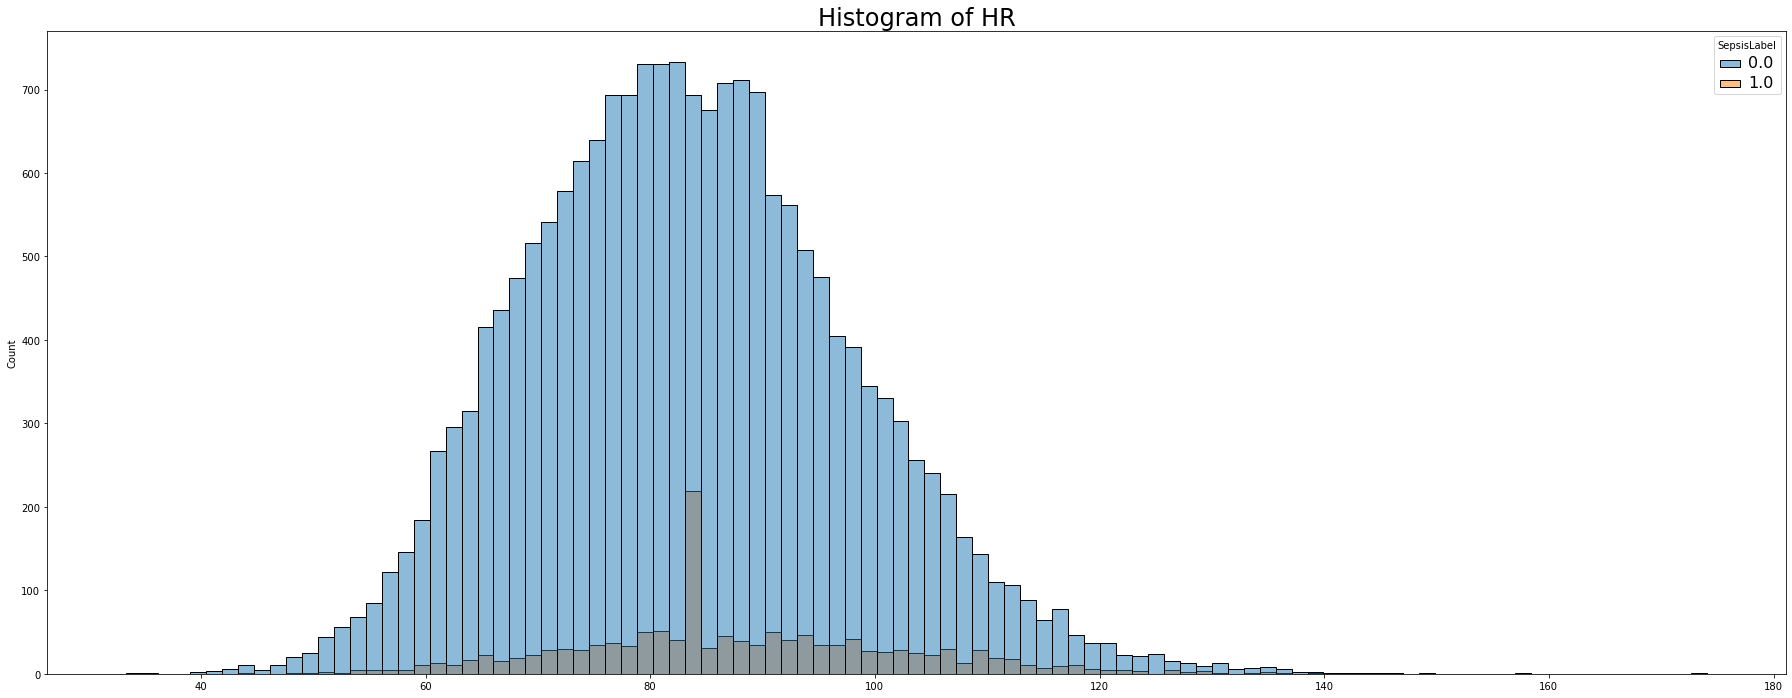

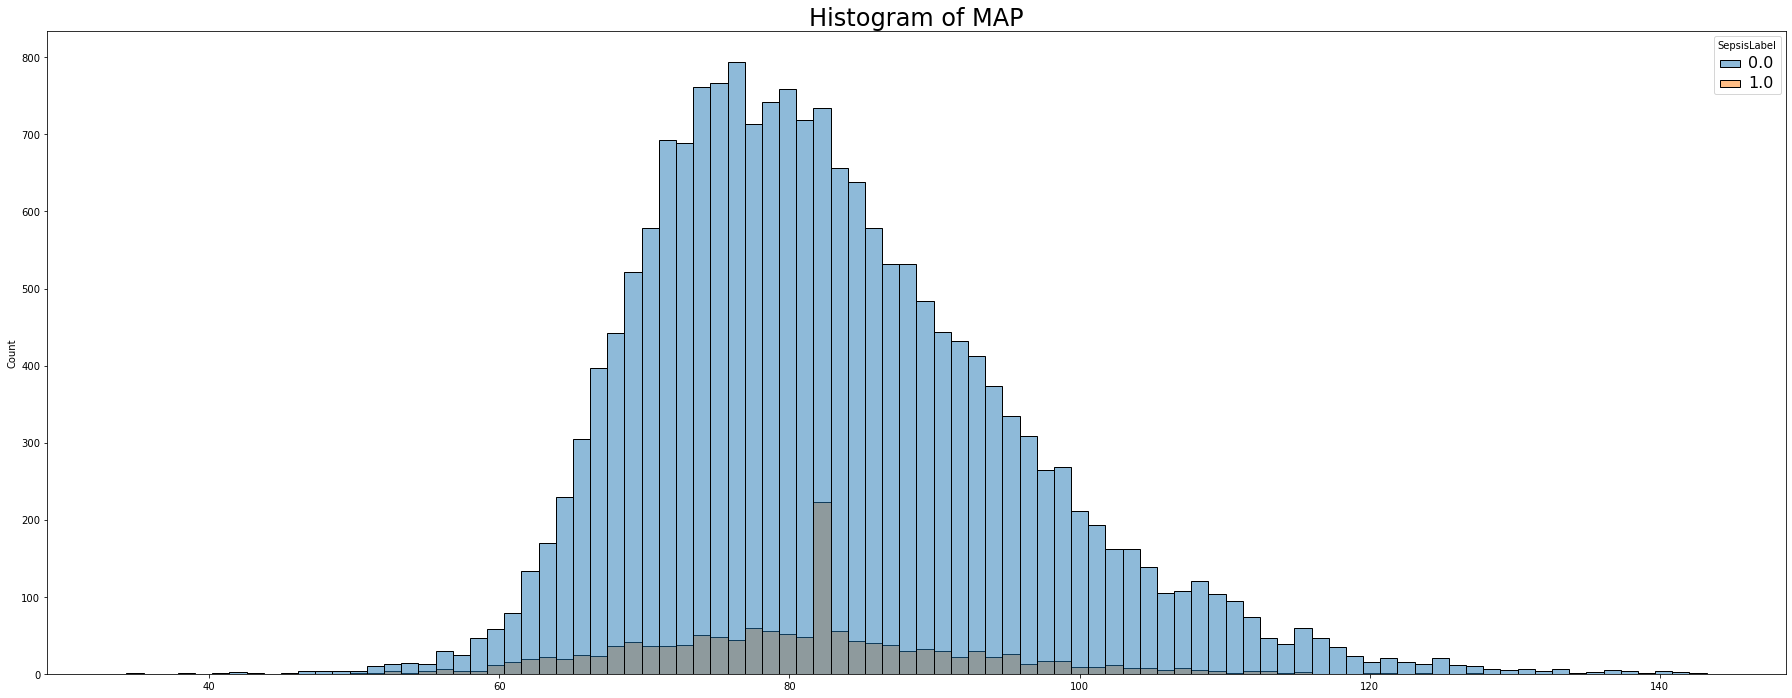

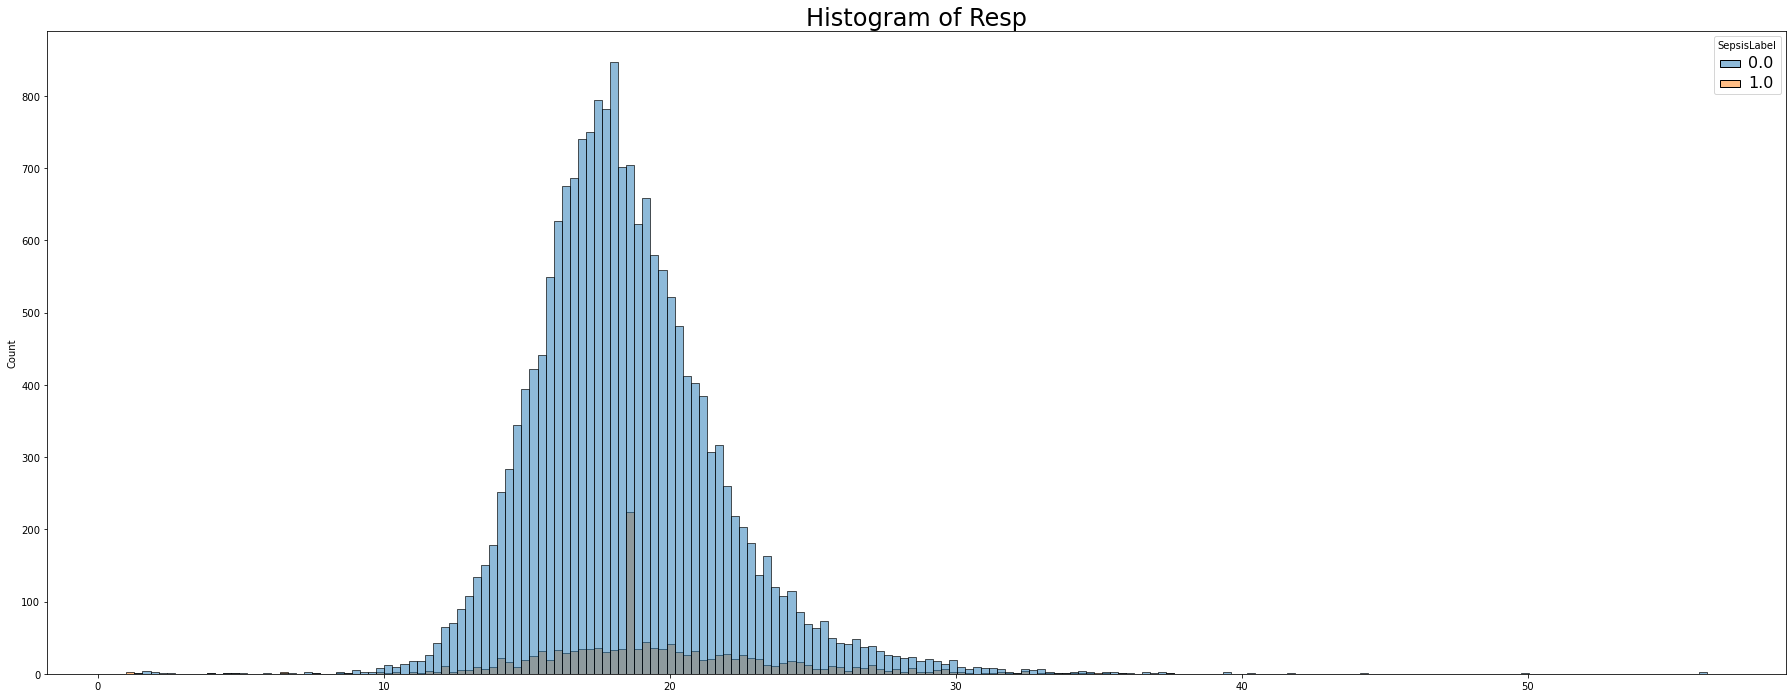

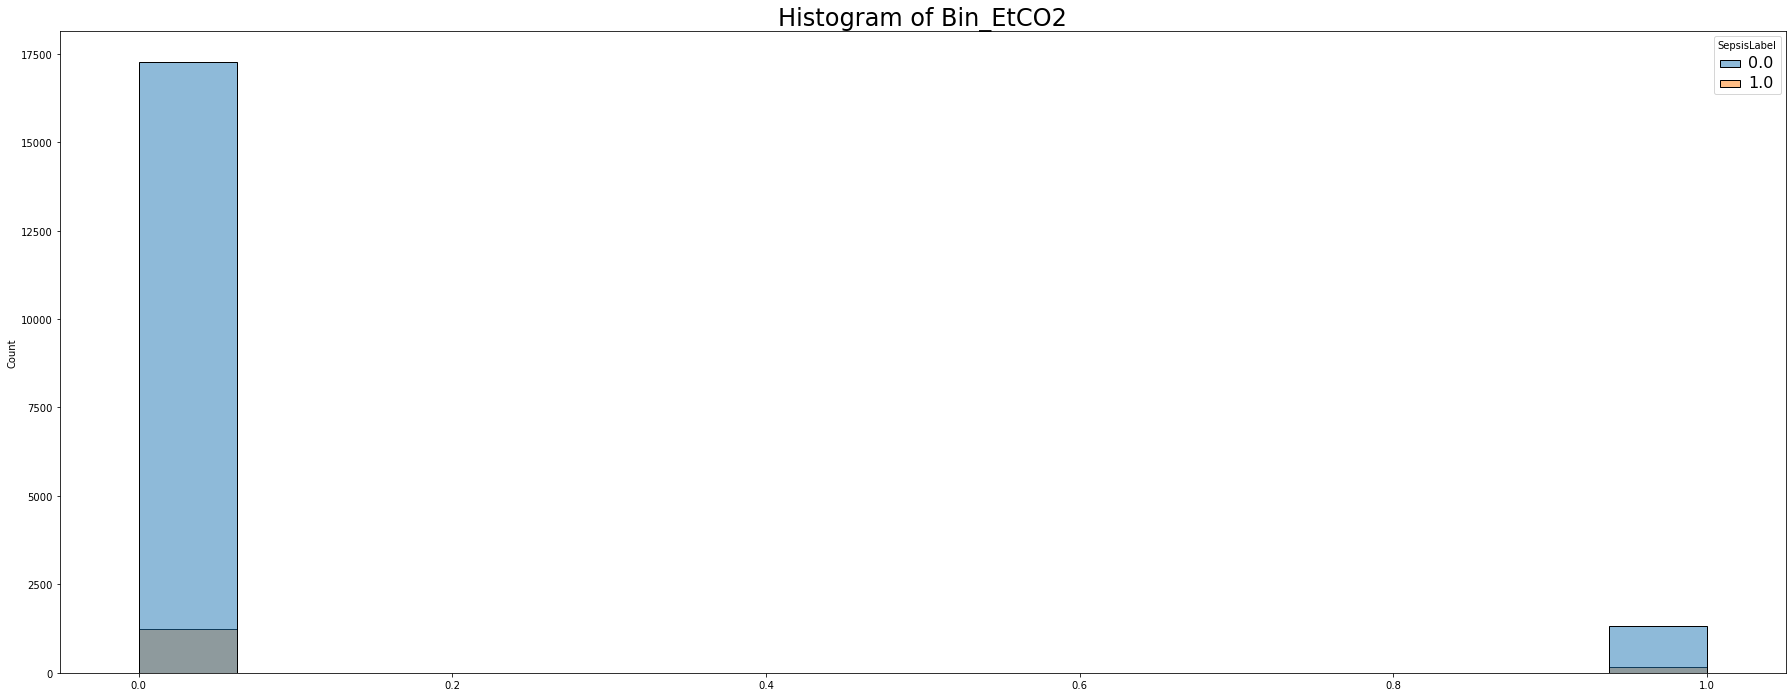

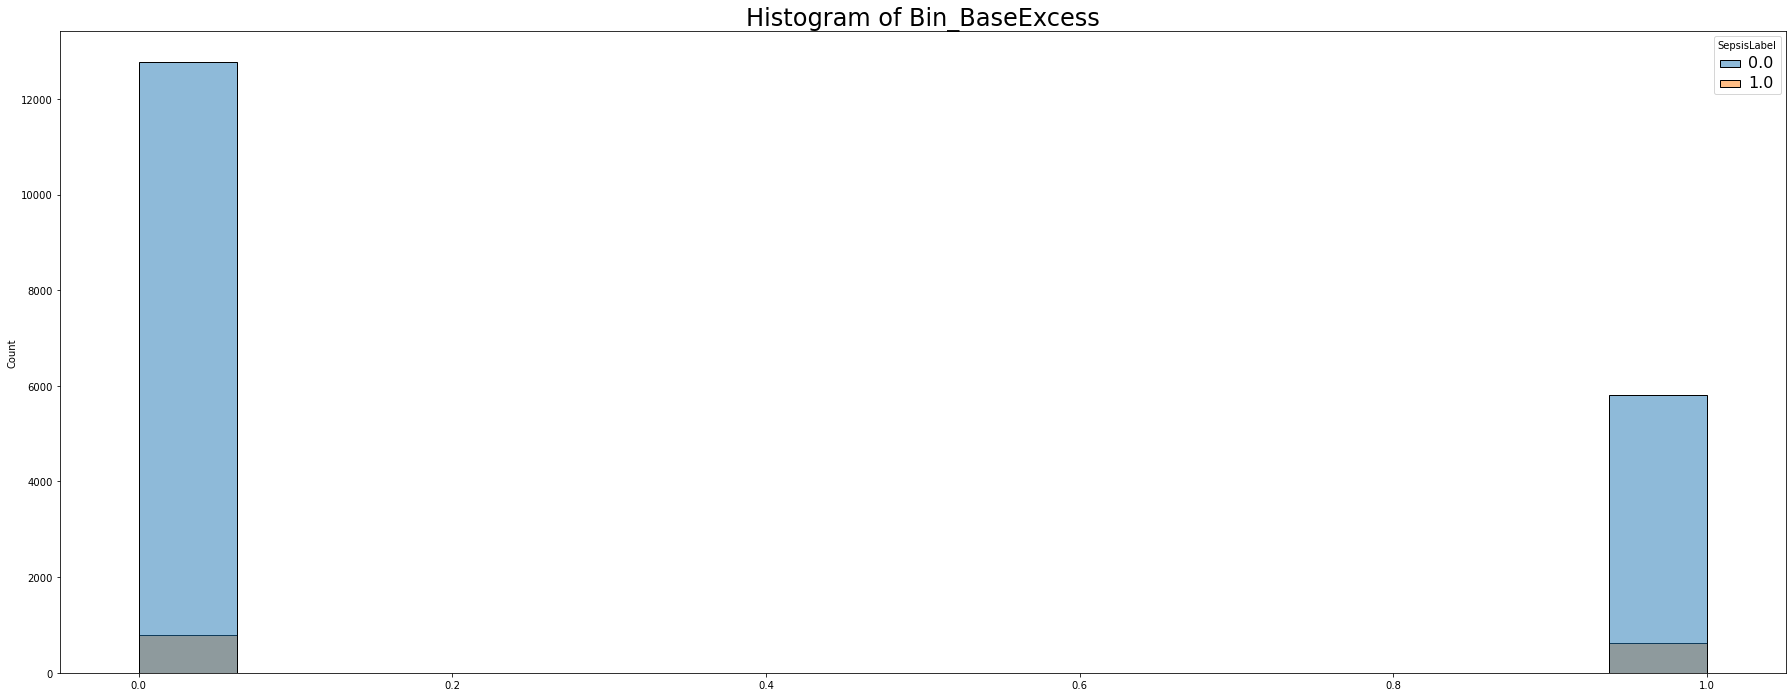

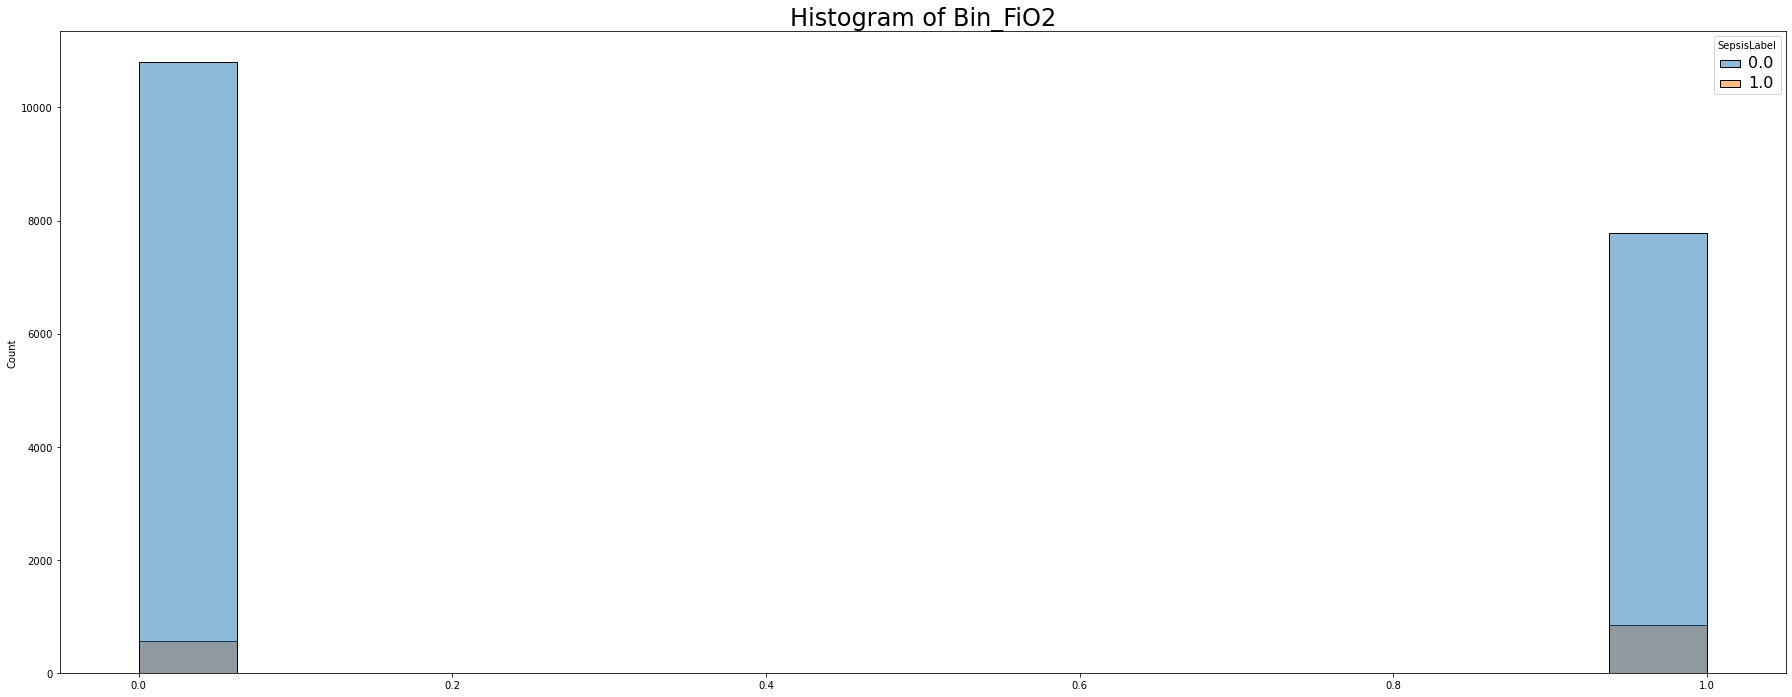

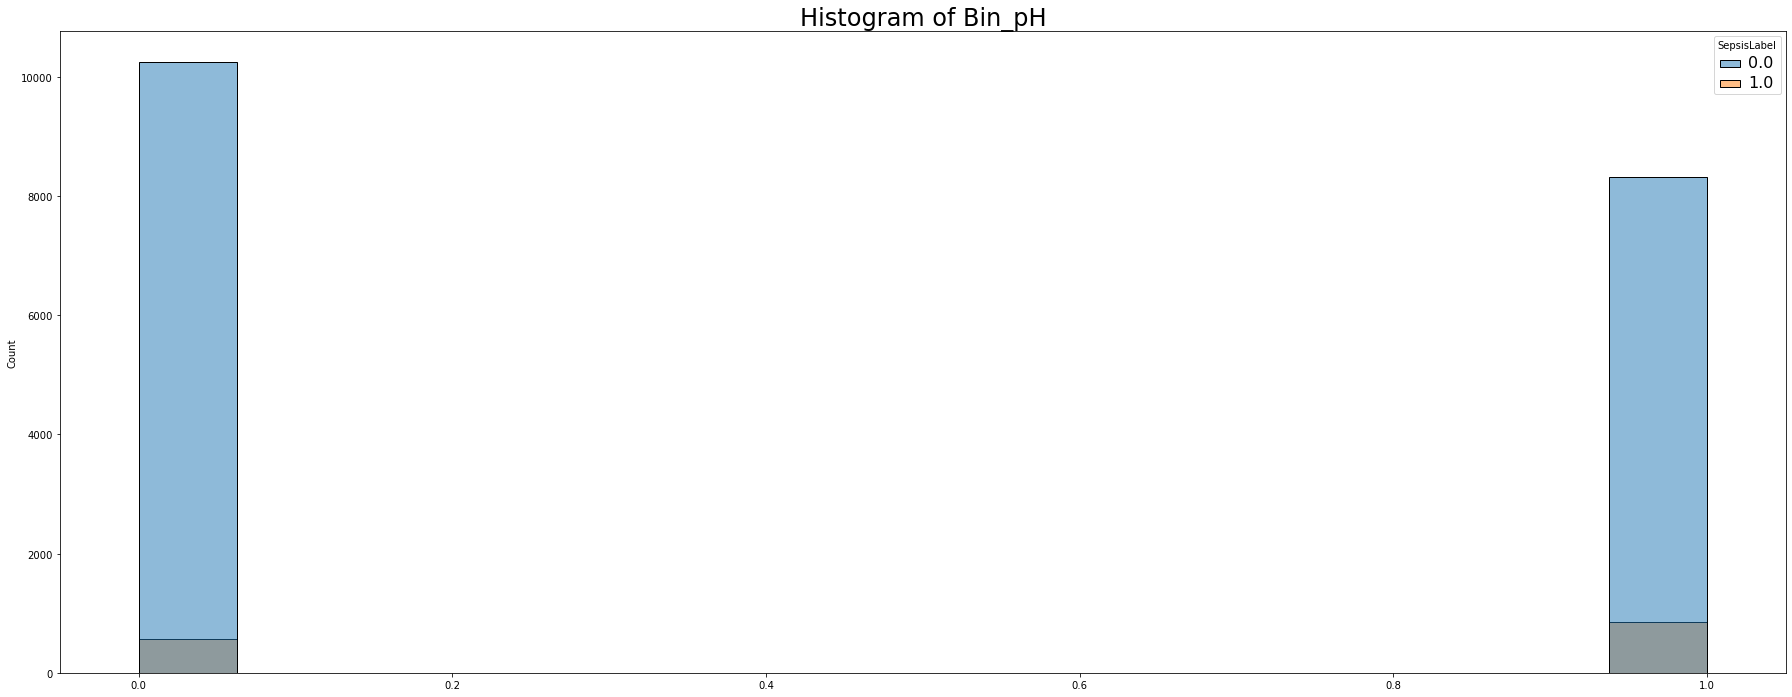

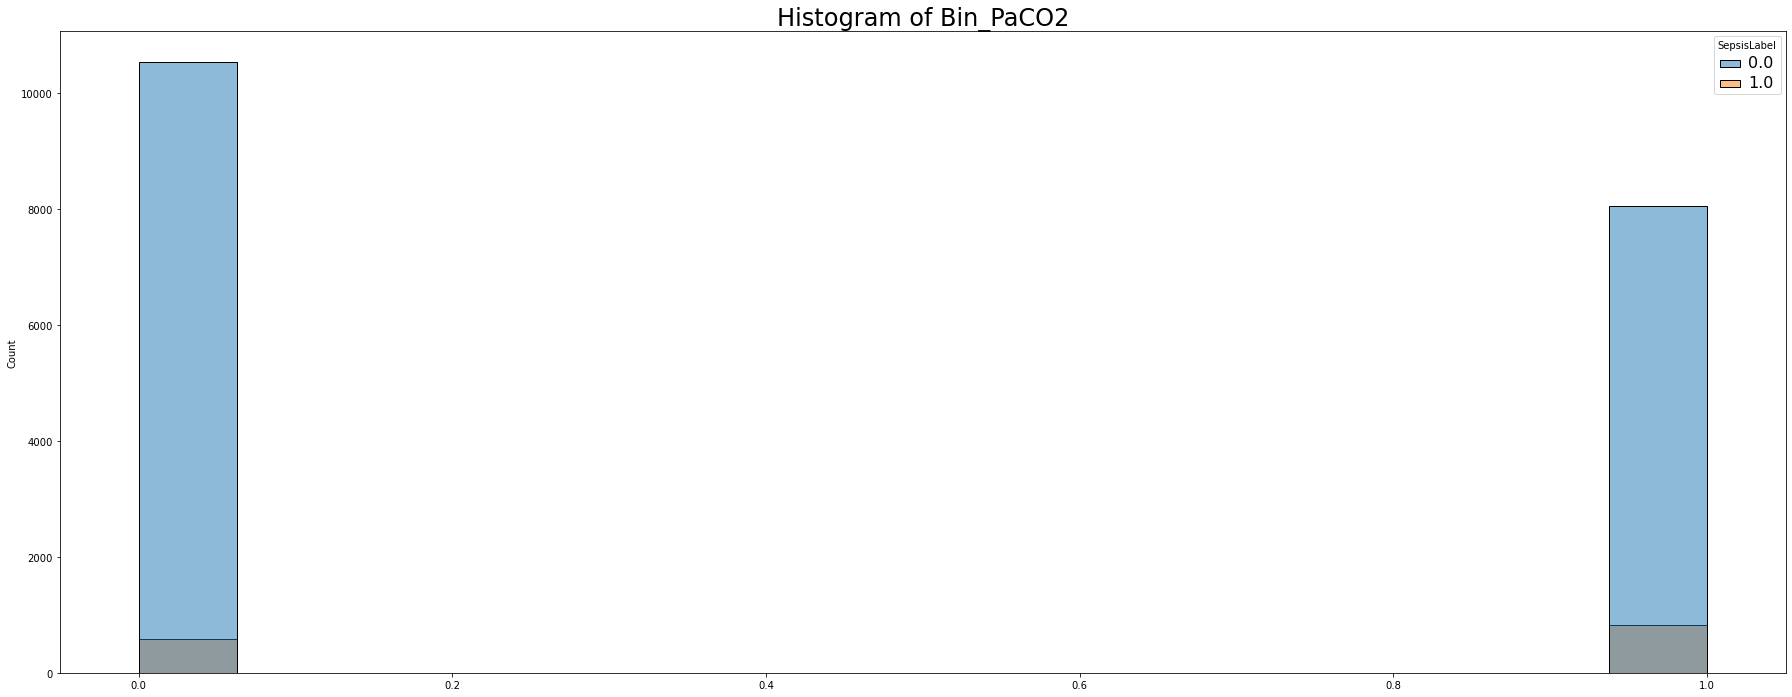

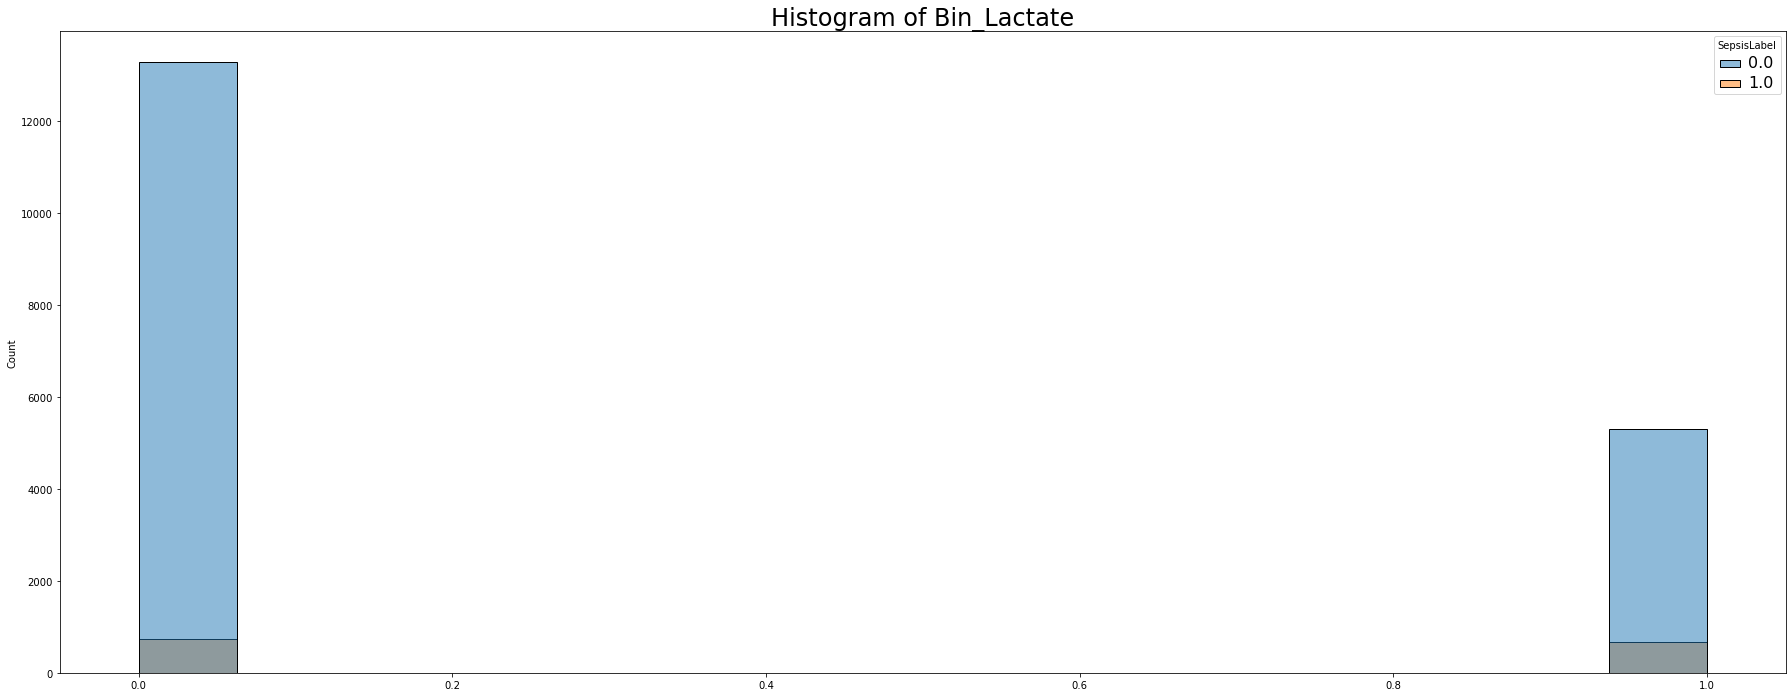

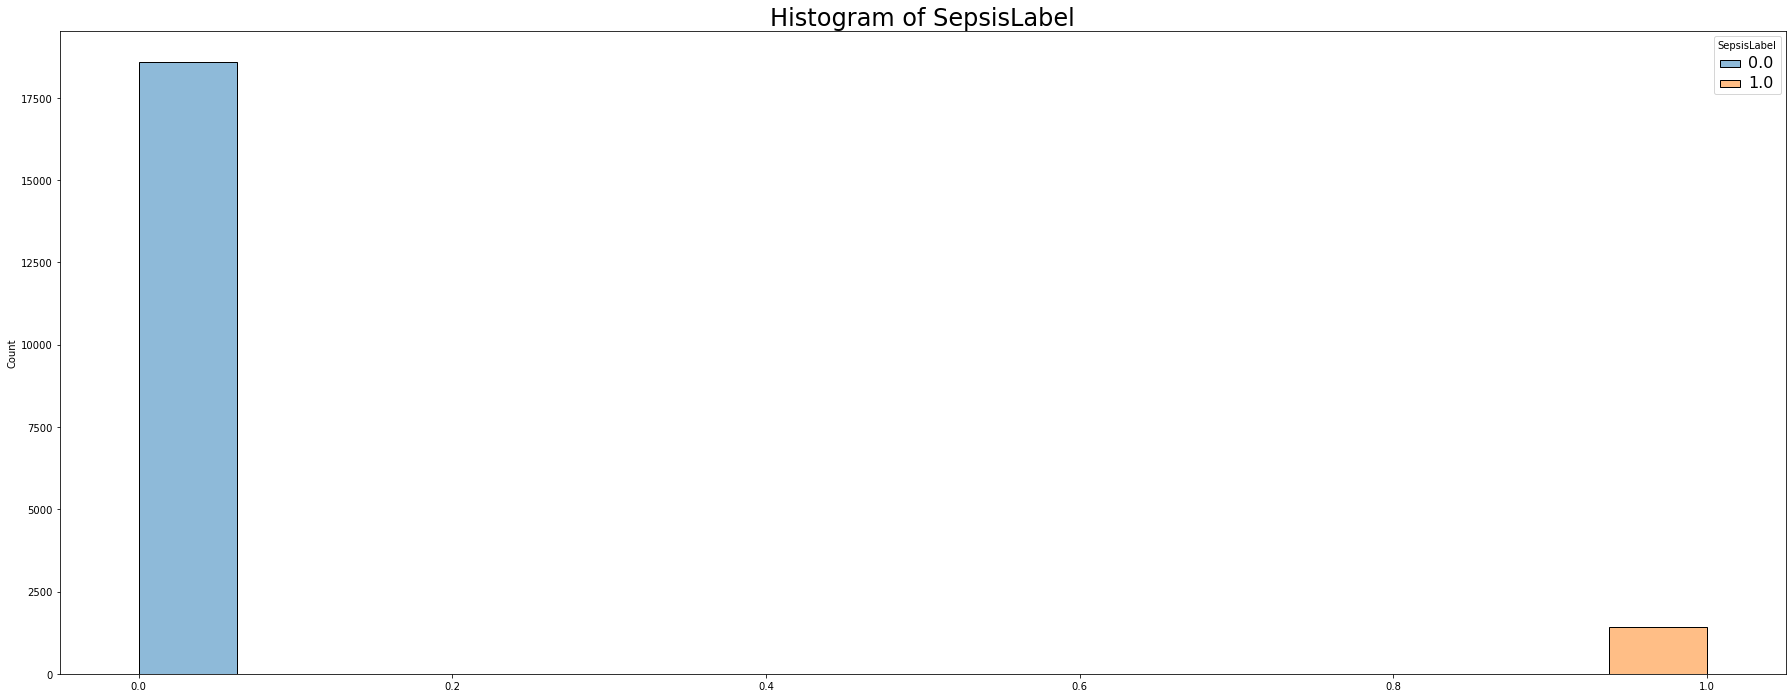

In [139]:
for feature in list(train_df_aggregated_filtered_new.columns):
    
    plt.figure(figsize=(25,10))
    axis = sns.histplot(x=feature, hue="SepsisLabel", data=train_df_aggregated_filtered_new)
    plt.title("Histogram of " + feature, fontsize=24)
    plt.tight_layout()
    plt.setp(axis.get_legend().get_texts(), fontsize='16') 
    plt.xlabel("")
    plt.show()

In [140]:
# Separate into train and test as well as features and predictor
X_without_label = train_df_aggregated_filtered_new.drop('SepsisLabel',axis=1) #Predictors
y = train_df_aggregated_filtered_new['SepsisLabel']
X = preprocessing.scale(X_without_label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11)

### Algorithm 1: Multi-layer Perceptron classifier

#### Hyperparameter selection, regularization

In [141]:
mlp = MLPClassifier(random_state=1)
parameters = {
    'hidden_layer_sizes': [(10,),(20,), (100,)],
    'activation': ['tanh', 'relu', 'logistic'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.01, 0.1,1],
    'learning_rate': ['constant','adaptive'],
}
clf = GridSearchCV(mlp, parameters, n_jobs=-1, cv=2)
clf.fit(X_train, y_train)

GridSearchCV(cv=2, estimator=MLPClassifier(random_state=1), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu', 'logistic'],
                         'alpha': [0.0001, 0.01, 0.1, 1],
                         'hidden_layer_sizes': [(10,), (20,), (100,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

In [143]:
clf.best_params_

{'activation': 'relu',
 'alpha': 0.1,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'solver': 'adam'}

#### Training and validation results

In [144]:
predictions = clf.predict(X_test)
print("F1: ", f1_score(y_test, predictions))
print("Accuracy: ", accuracy_score(y_test, predictions))
print("Precision: ", precision_score(y_test, predictions))
print("Recall: ", recall_score(y_test, predictions))

F1:  0.6541244573082489
Accuracy:  0.9601666666666666
Precision:  0.8528301886792453
Recall:  0.5305164319248826


#### Post analysis comparing predicted labels on each feature- MLP

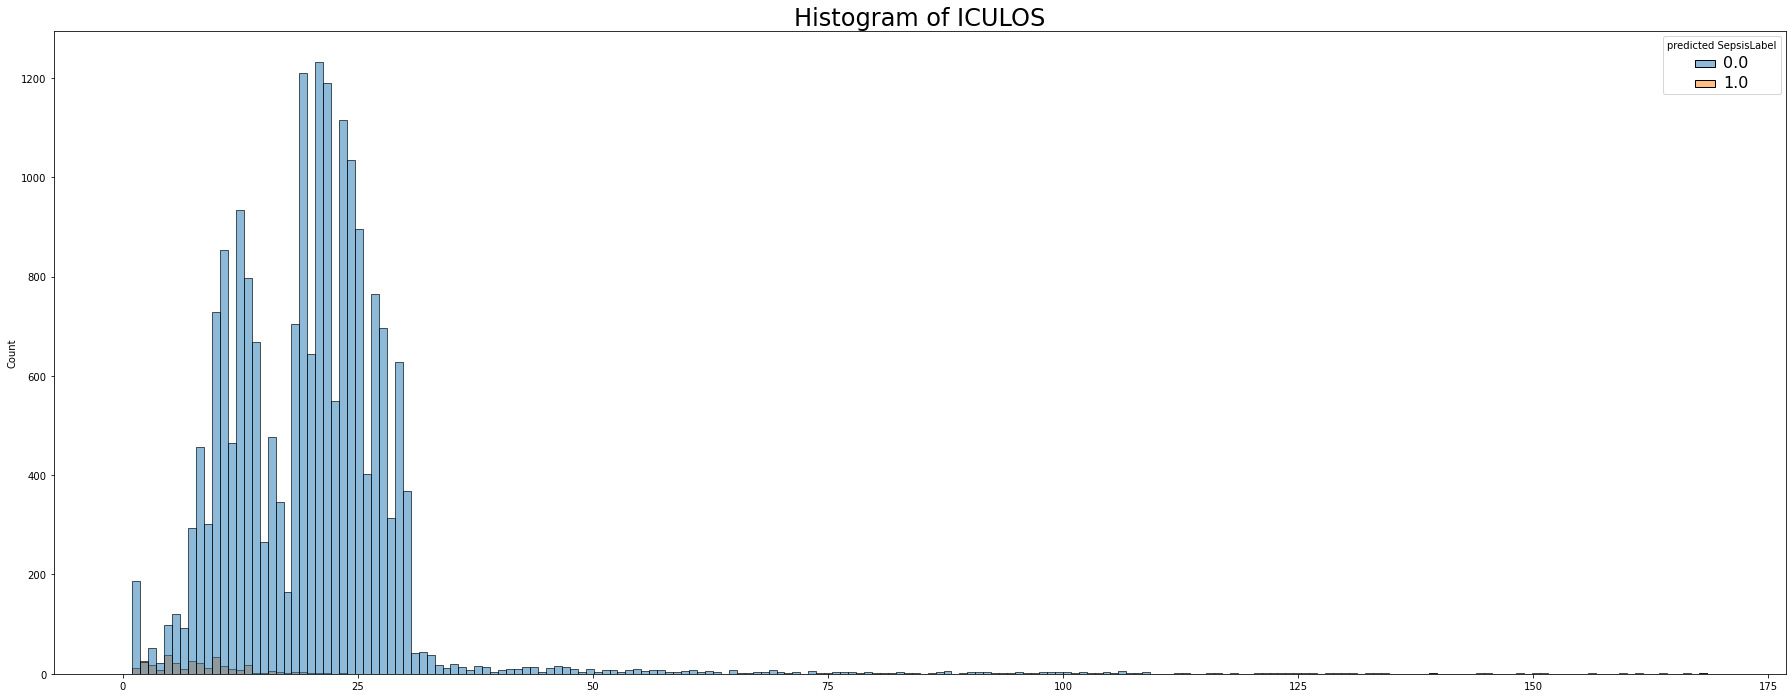

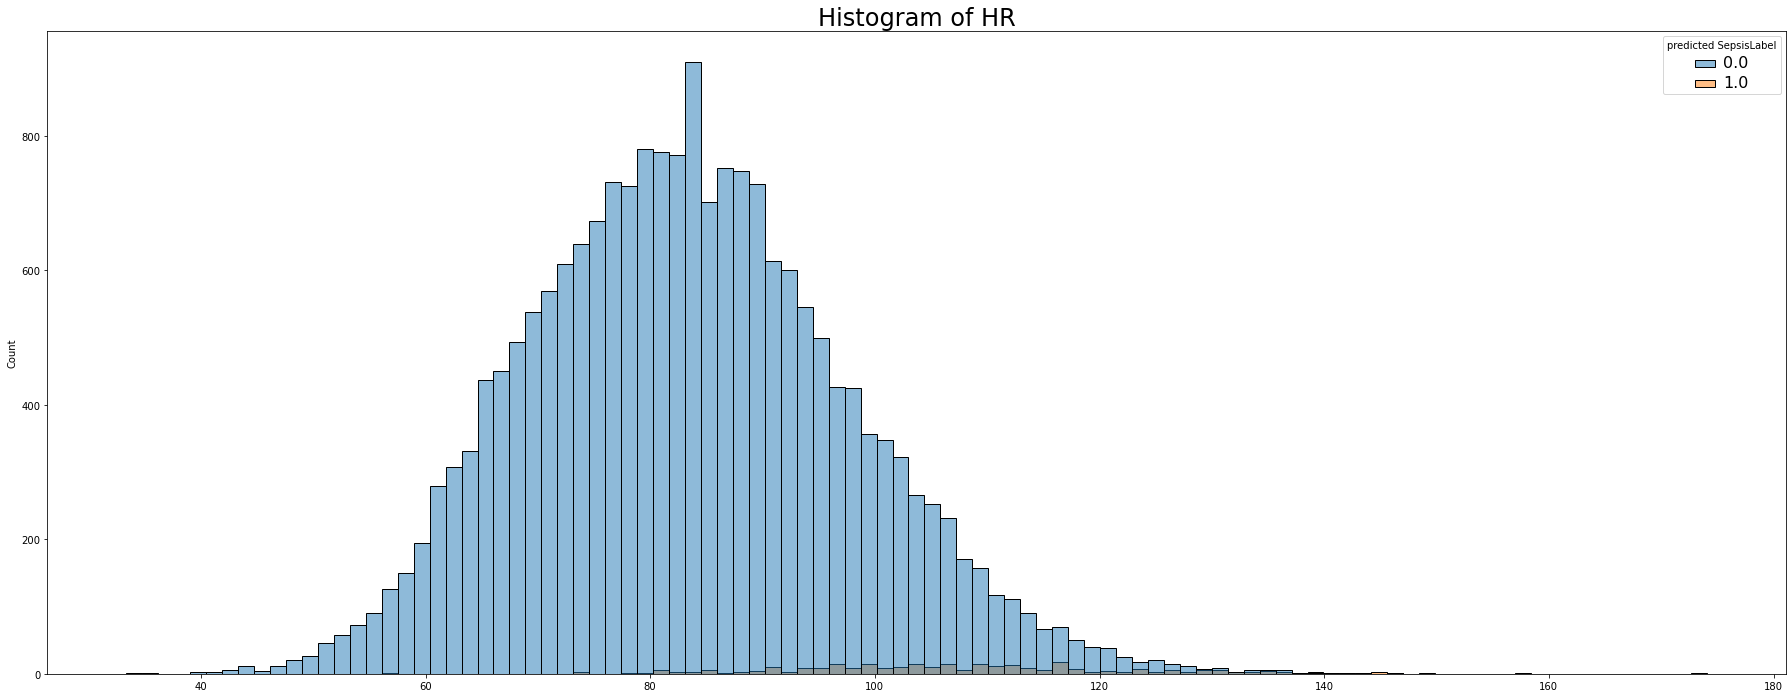

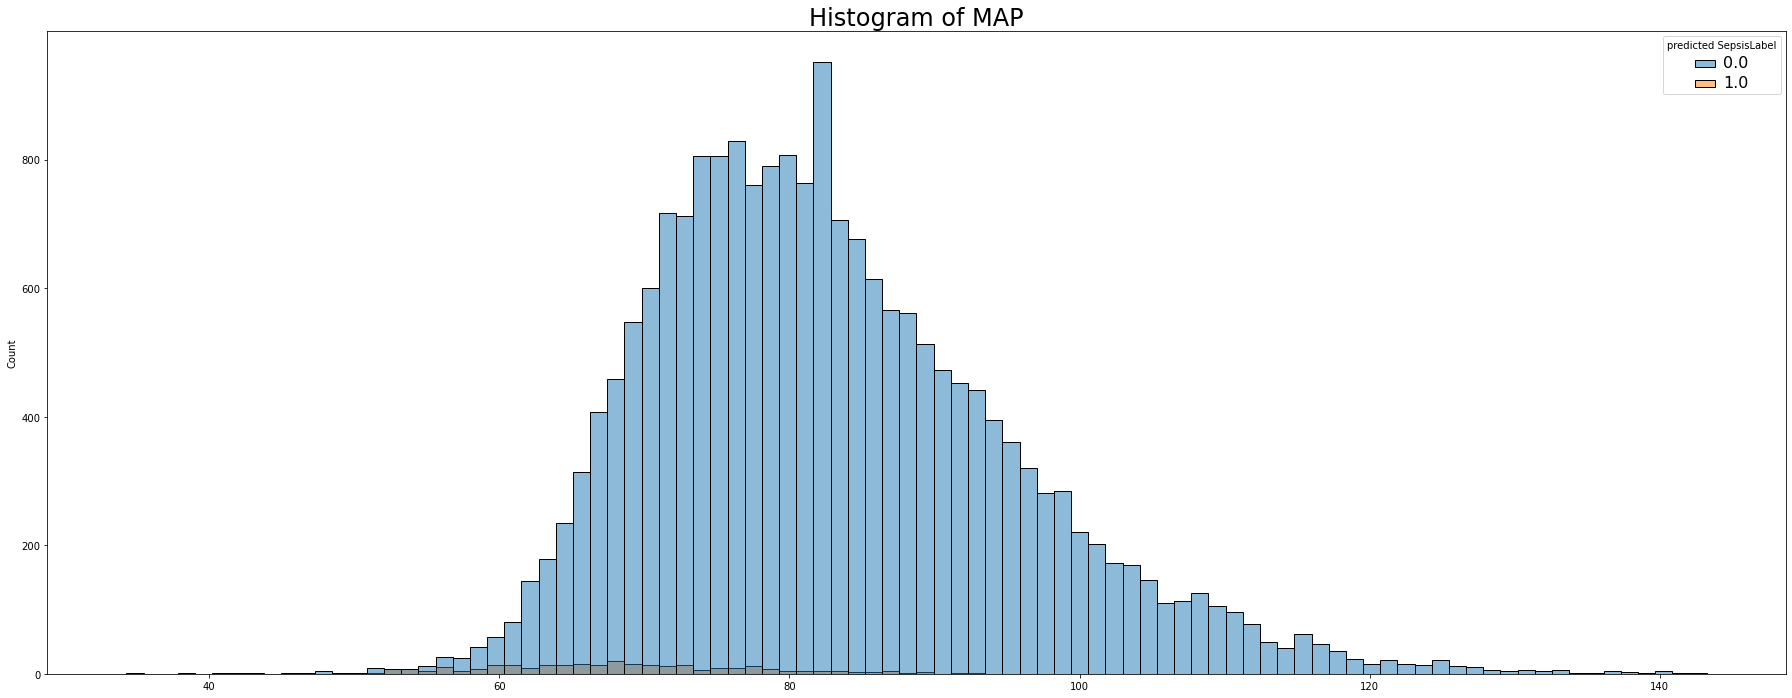

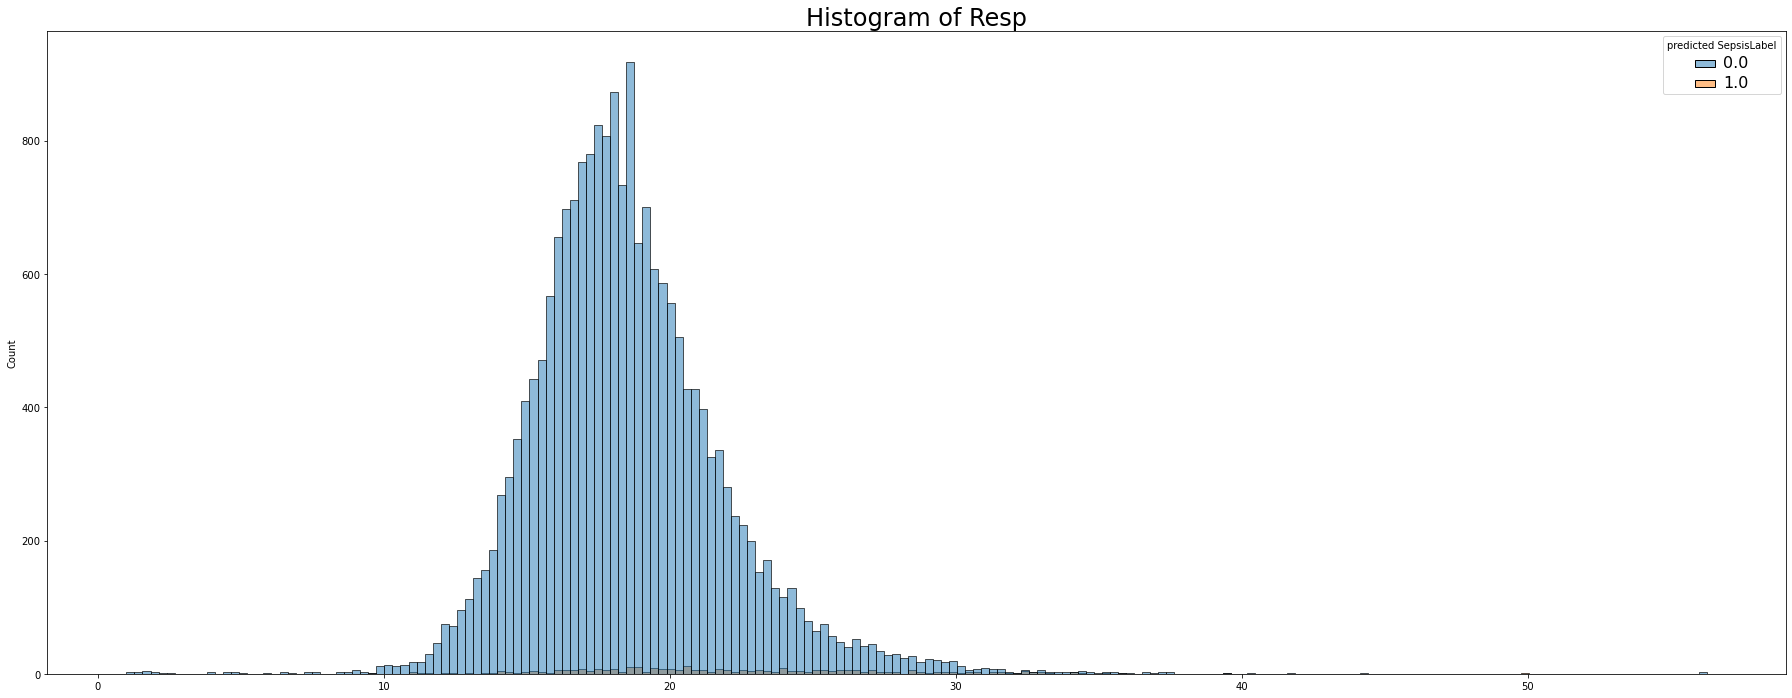

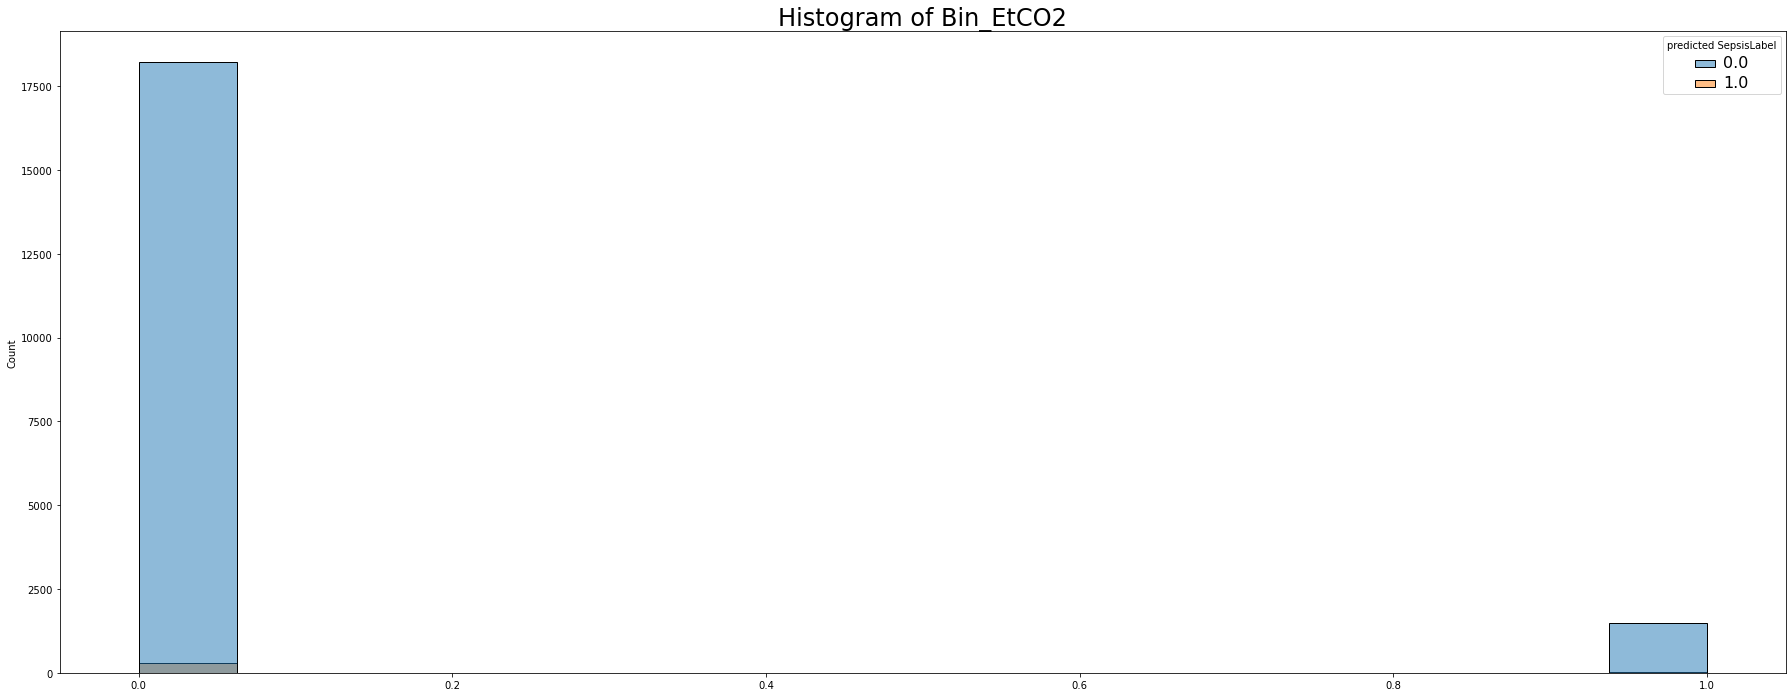

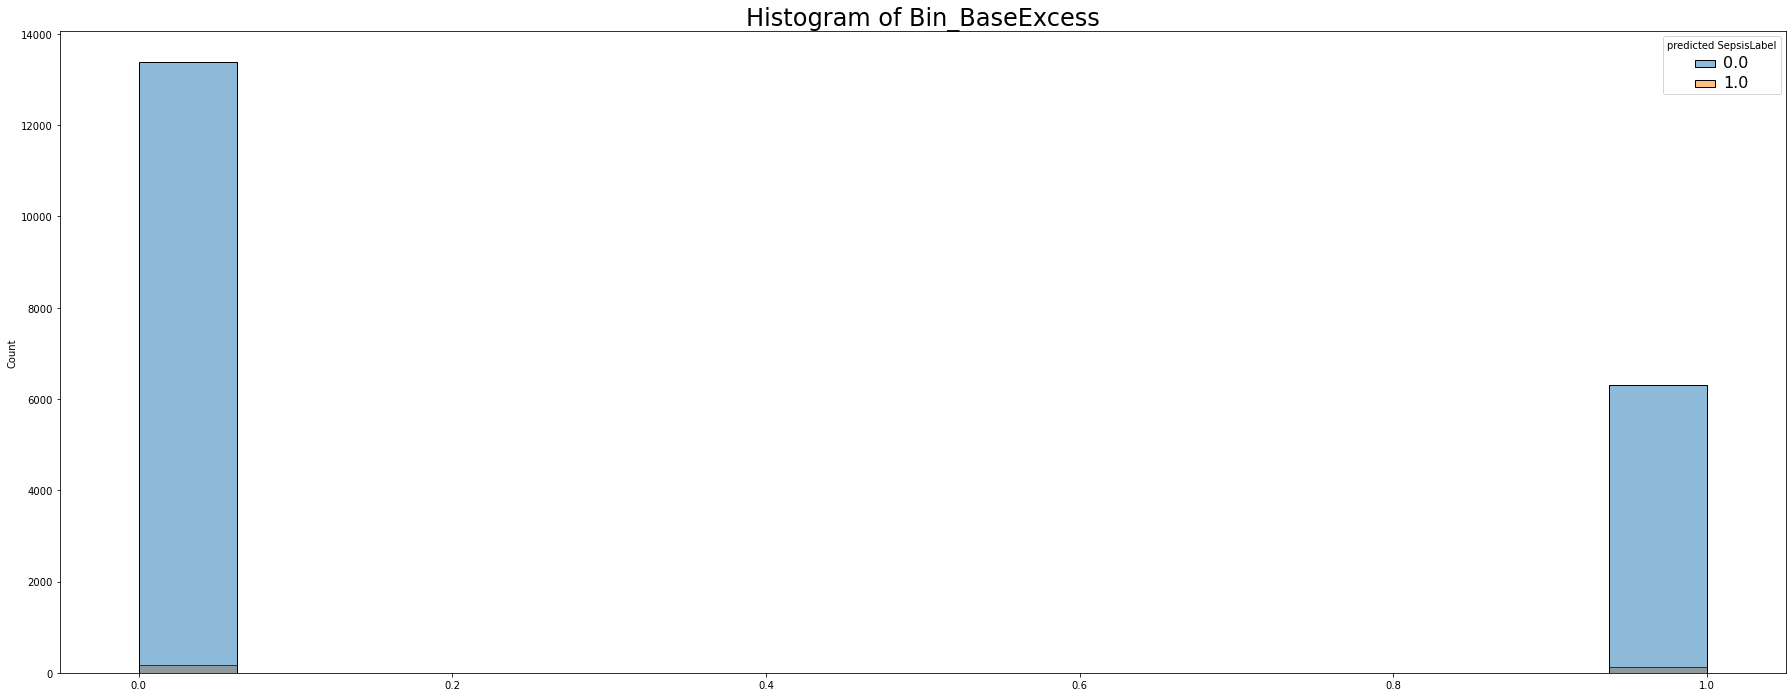

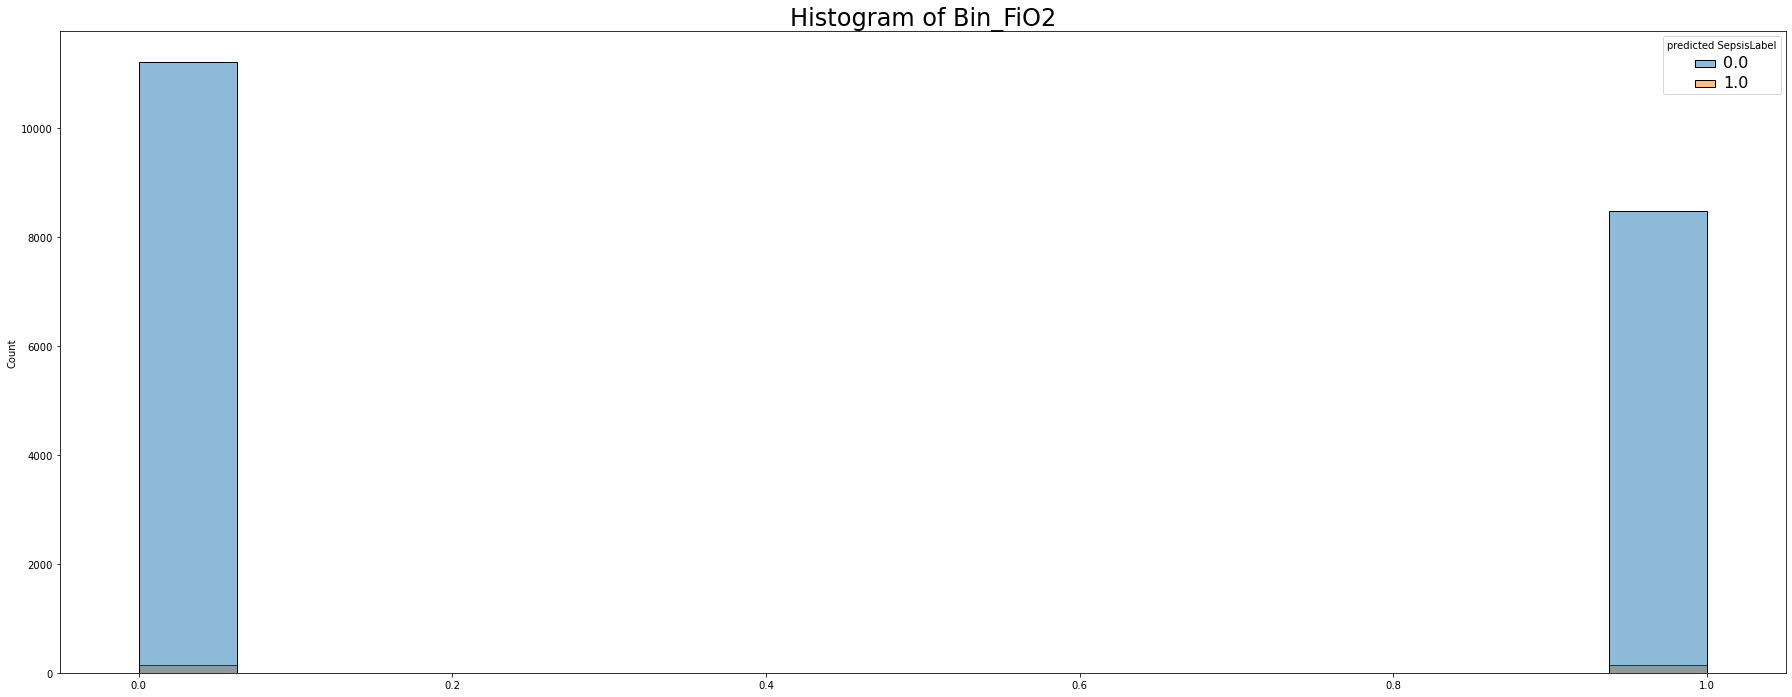

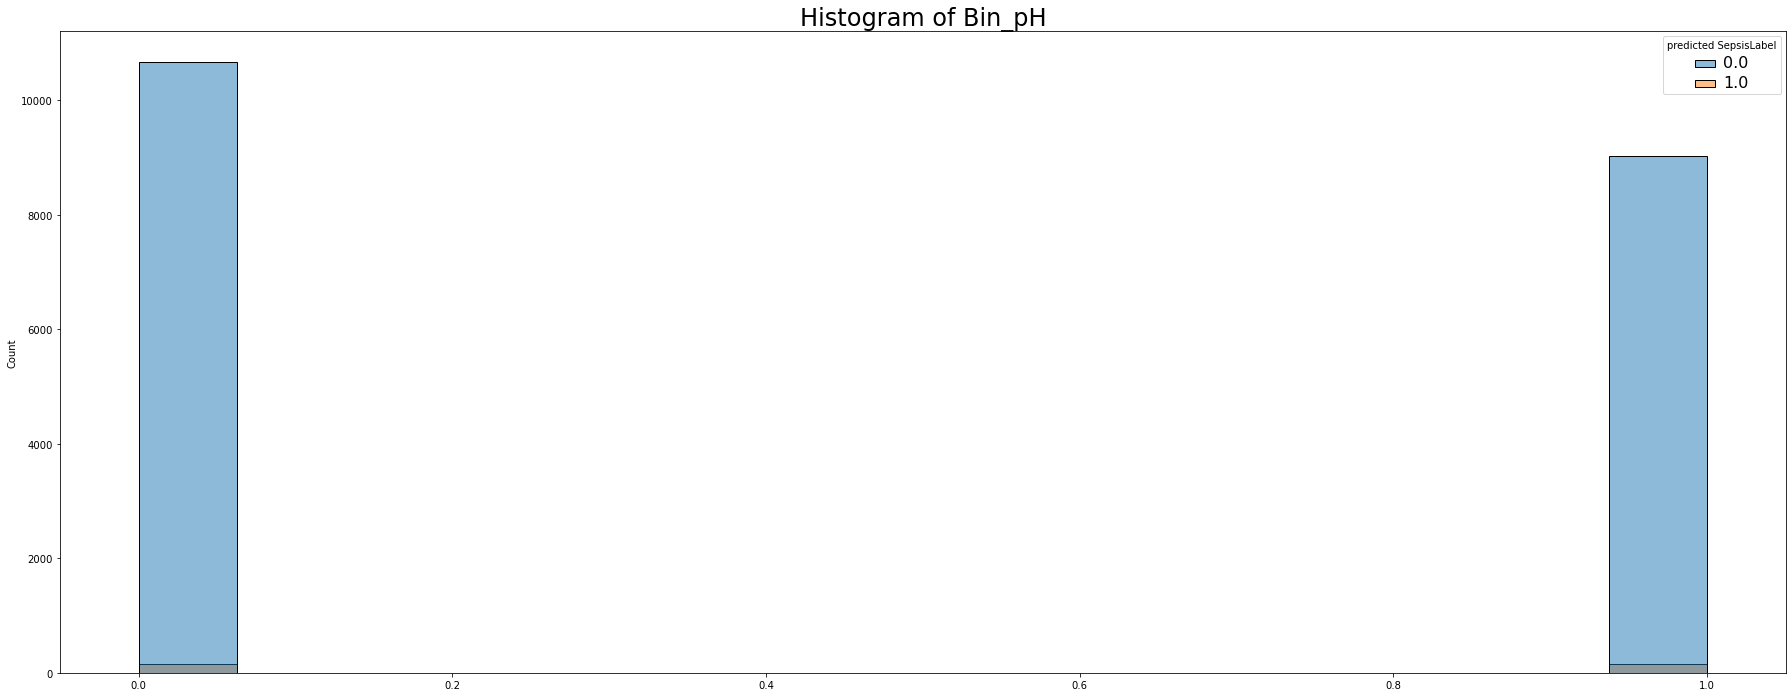

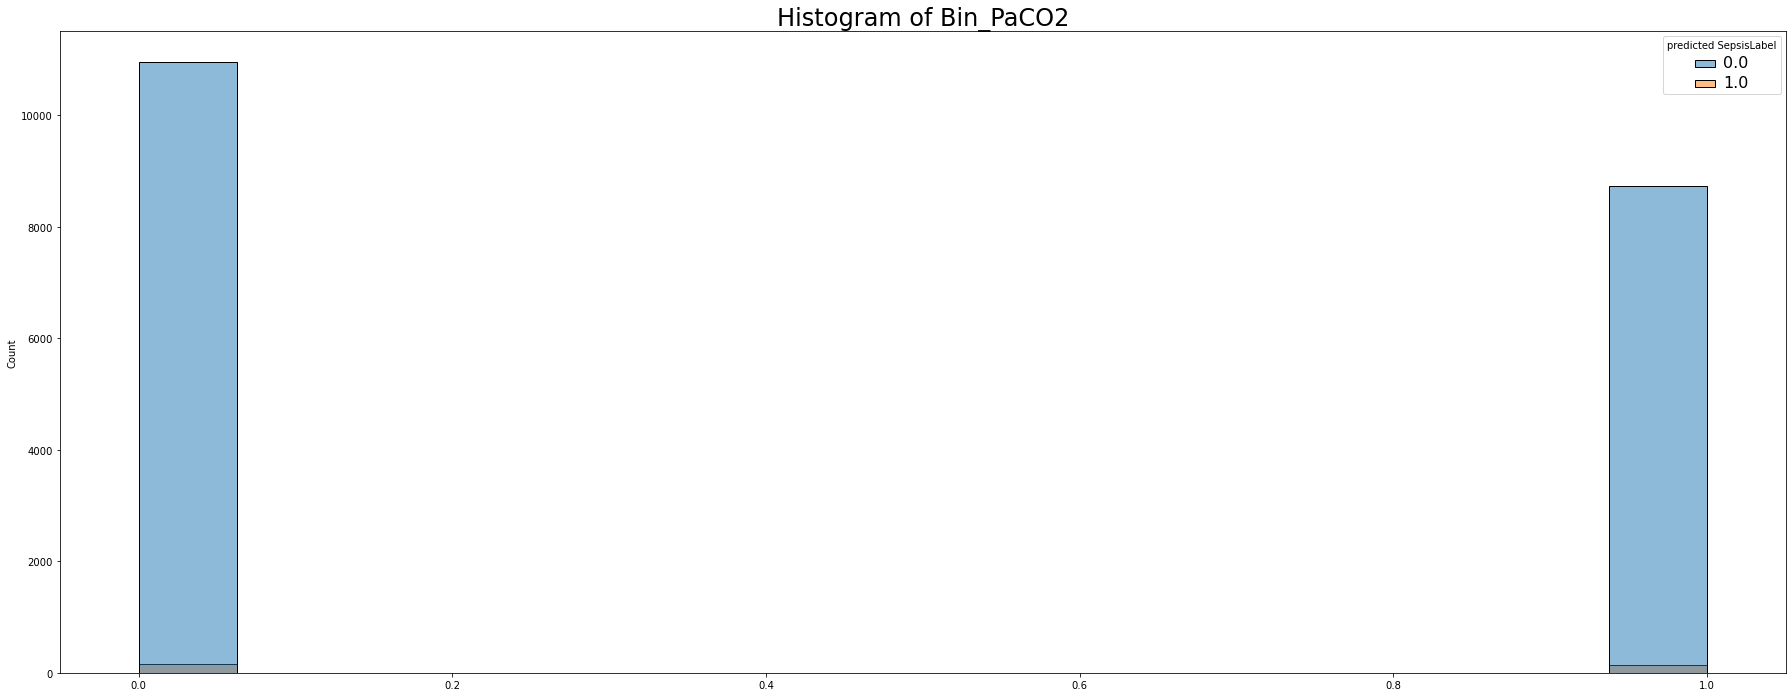

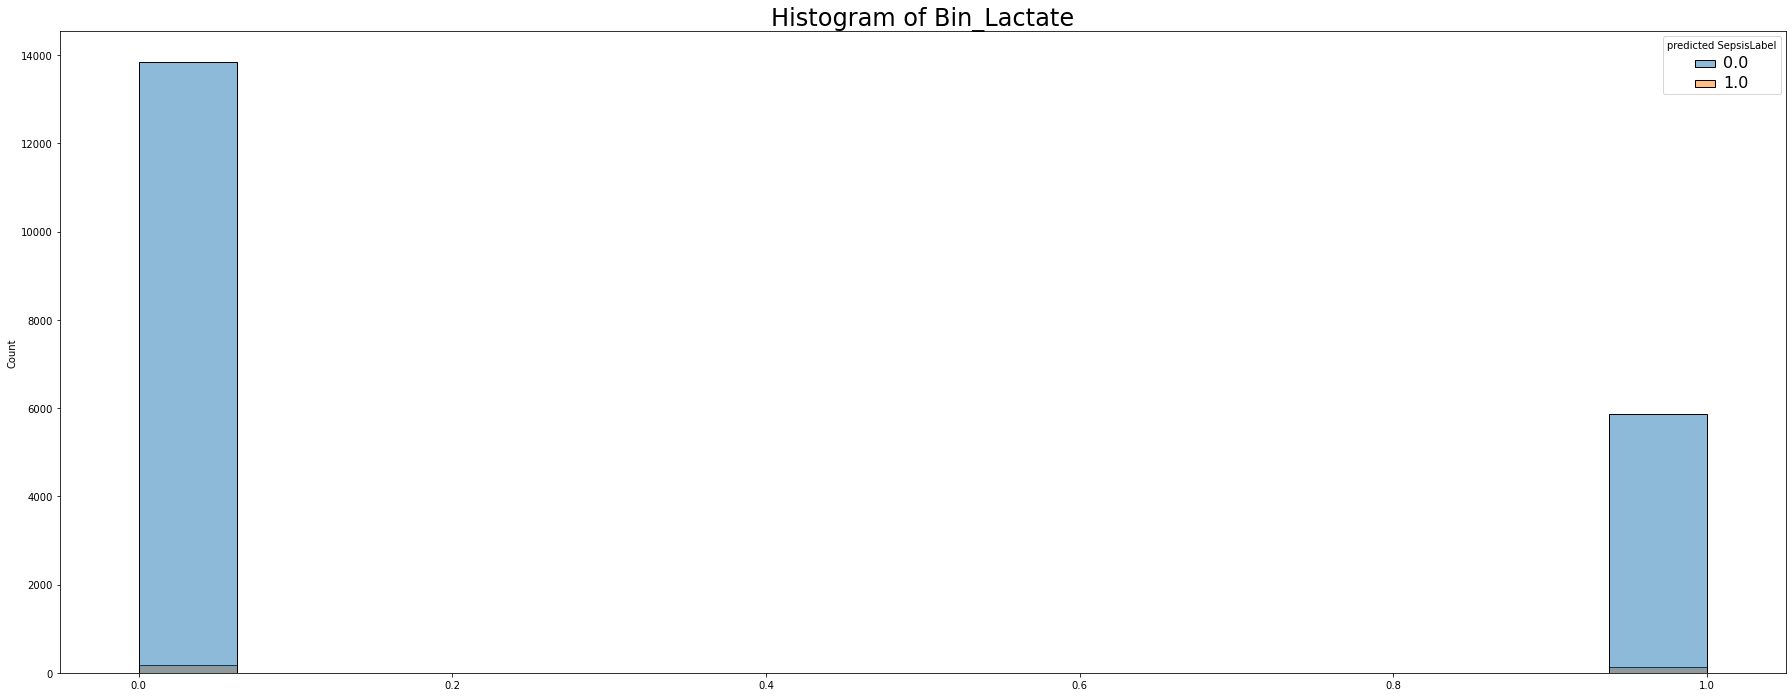

In [156]:
post_analysis(train_df_aggregated_filtered_new,clf)

### Algorithm 2: XGBoost
Credits: https://towardsdatascience.com/beginners-guide-to-xgboost-for-classification-problems-50f75aac5390

#### Hyperparameter selection, regularization

In [145]:
xgb = XGBRegressor(random_state=1)

parameters= {
    'n_estimators': [100,200,500],
    "max_depth": [3,6,9],
    "gamma": [0.01,0.1,1],
    "learning_rate": [0.001,0.01,0.1,1]

}

clf_2 = GridSearchCV(xgb, parameters, n_jobs=-1, cv=2)
clf_2.fit(X_train, y_train)
clf_2.best_params_

{'gamma': 1, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 200}

In [146]:
xgb_cl = XGBClassifier(random_state=1)
parameters= {
    'n_estimators': [100,200,500],
    "max_depth": [3,6,9],
    "gamma": [0.01,0.1,1],
    "learning_rate": [0.001,0.01,0.1,1]

}

clf_2 = GridSearchCV(xgb_cl, parameters, n_jobs=-1, cv=2)
clf_2.fit(X_train, y_train)
clf_2.best_params_

{'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}

#### Training and validation results

In [147]:
xgb_cl_best = XGBClassifier(gamma= 0.1, learning_rate=0.01, max_depth=6, n_estimators=200, random_state=1)

xgb_cl_best.fit(X_train, y_train)
predictions_c = xgb_cl_best.predict(X_test)
#predictions_2 = np.where(predictions_2>0.5,1,0)
print("F1: ", f1_score(y_test, predictions_c))
print("Accuracy: ", accuracy_score(y_test, predictions_c))
print("Precision: ", precision_score(y_test, predictions_c))
print("Recall: ", recall_score(y_test, predictions_c))

F1:  0.6780141843971631
Accuracy:  0.9621666666666666
Precision:  0.8566308243727598
Recall:  0.5610328638497653


In [148]:
xgb_best = XGBRegressor(gamma= 1, learning_rate=0.1, max_depth=9, n_estimators=200, random_state=1)
xgb_best.fit(X_train, y_train)
predictions_2 = xgb_best.predict(X_test)
predictions_2 = np.where(predictions_2>0.5,1,0)
print("F1: ", f1_score(y_test, predictions_2))
print("Accuracy: ", accuracy_score(y_test, predictions_2))
print("Precision: ", precision_score(y_test, predictions_2))
print("Recall: ", recall_score(y_test, predictions_2))

F1:  0.688293370944993
Accuracy:  0.9631666666666666
Precision:  0.8621908127208481
Recall:  0.5727699530516432


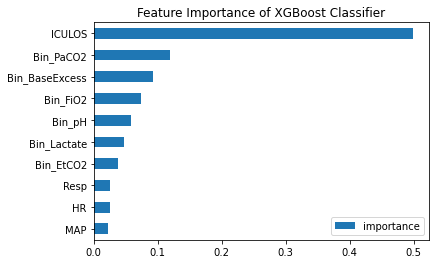

In [157]:
feature_importance = pd.DataFrame(xgb_cl_best.feature_importances_,
                                  X_without_label.columns,
                                  columns=['importance'])
feature_importance.sort_values('importance').plot(kind='barh', title='Feature Importance of XGBoost Classifier')

#### Post analysis comparing predicted labels on each feature- XGB

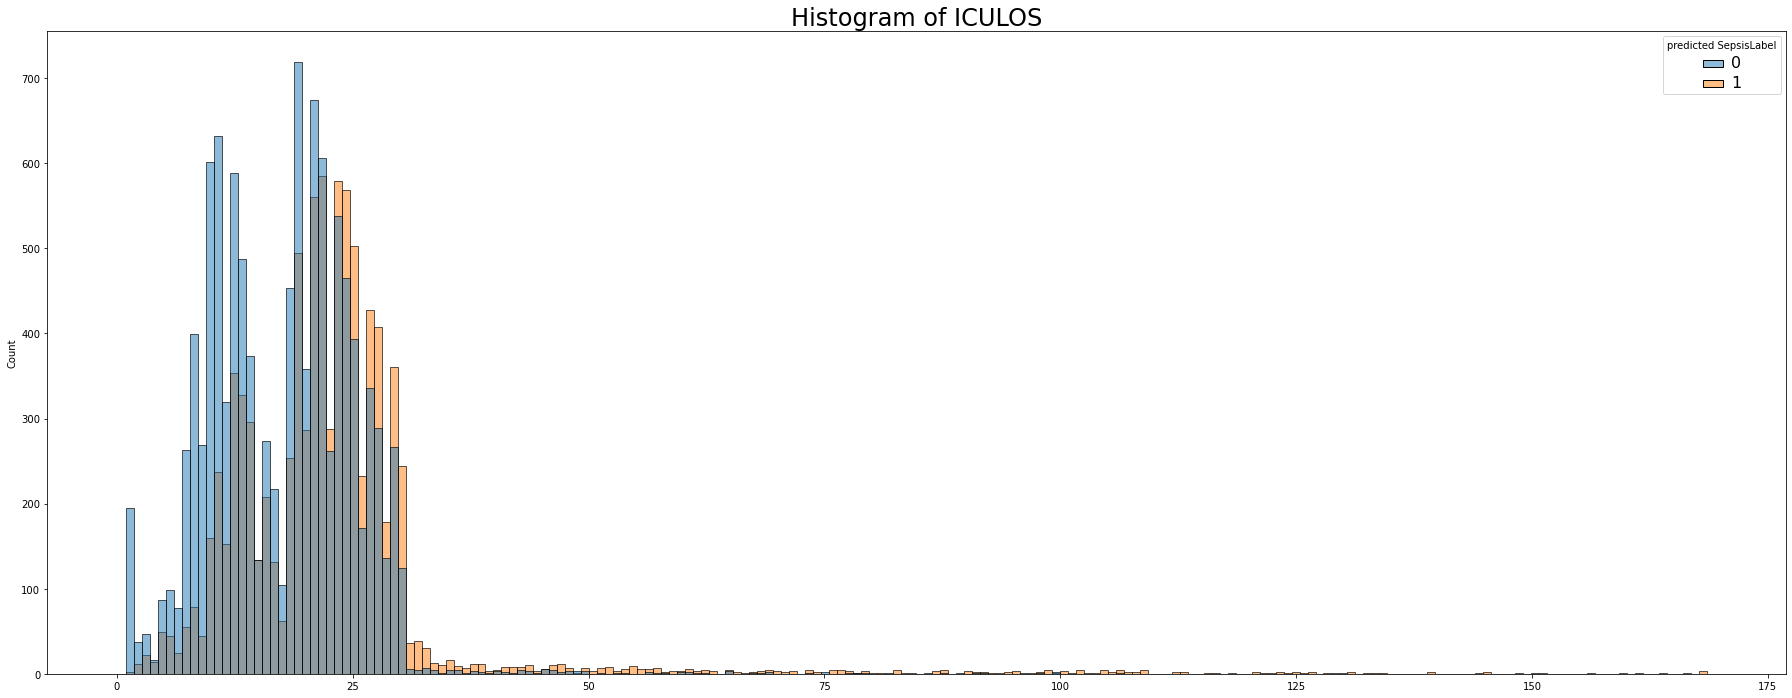

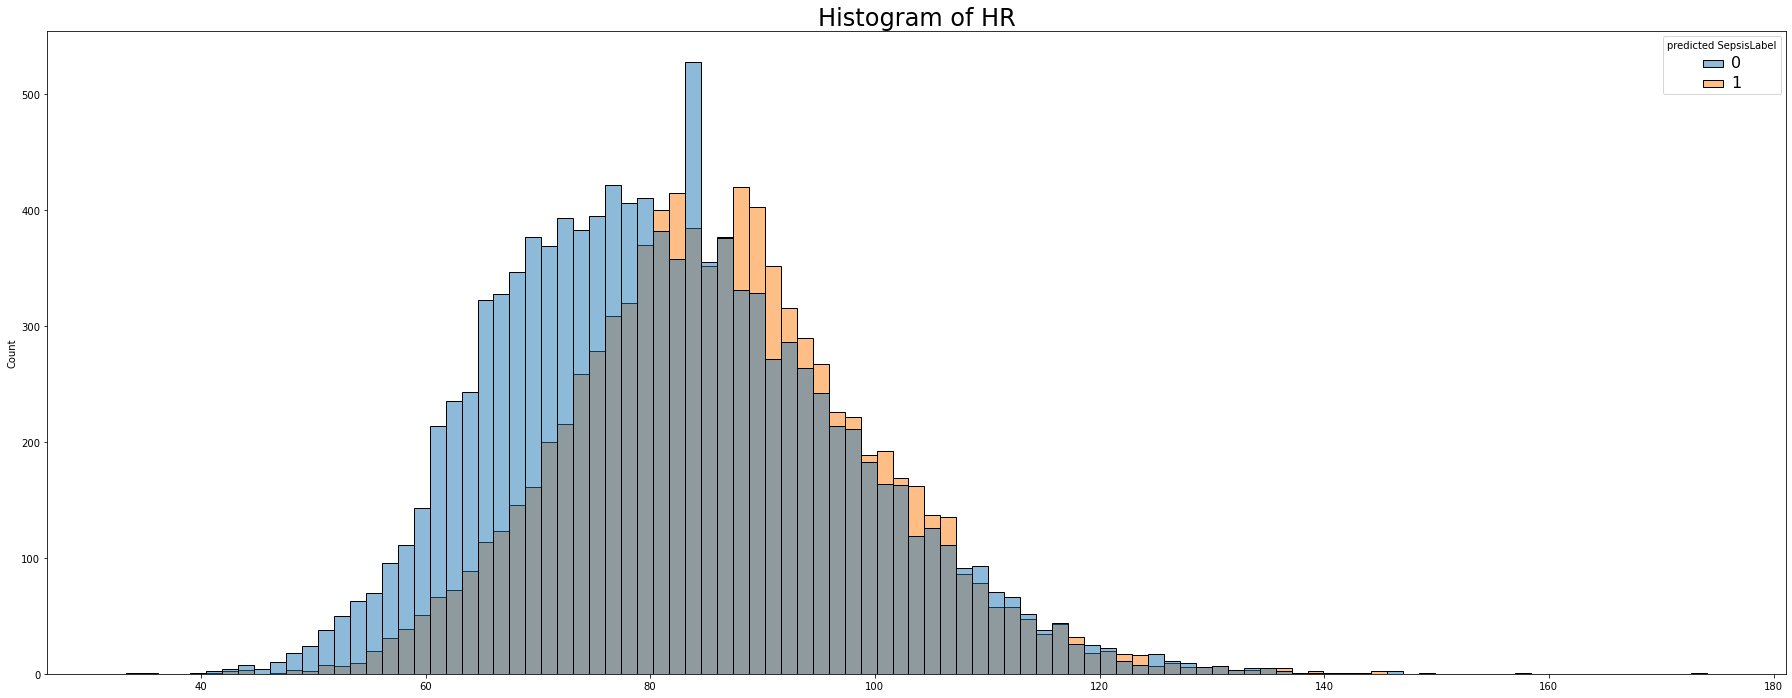

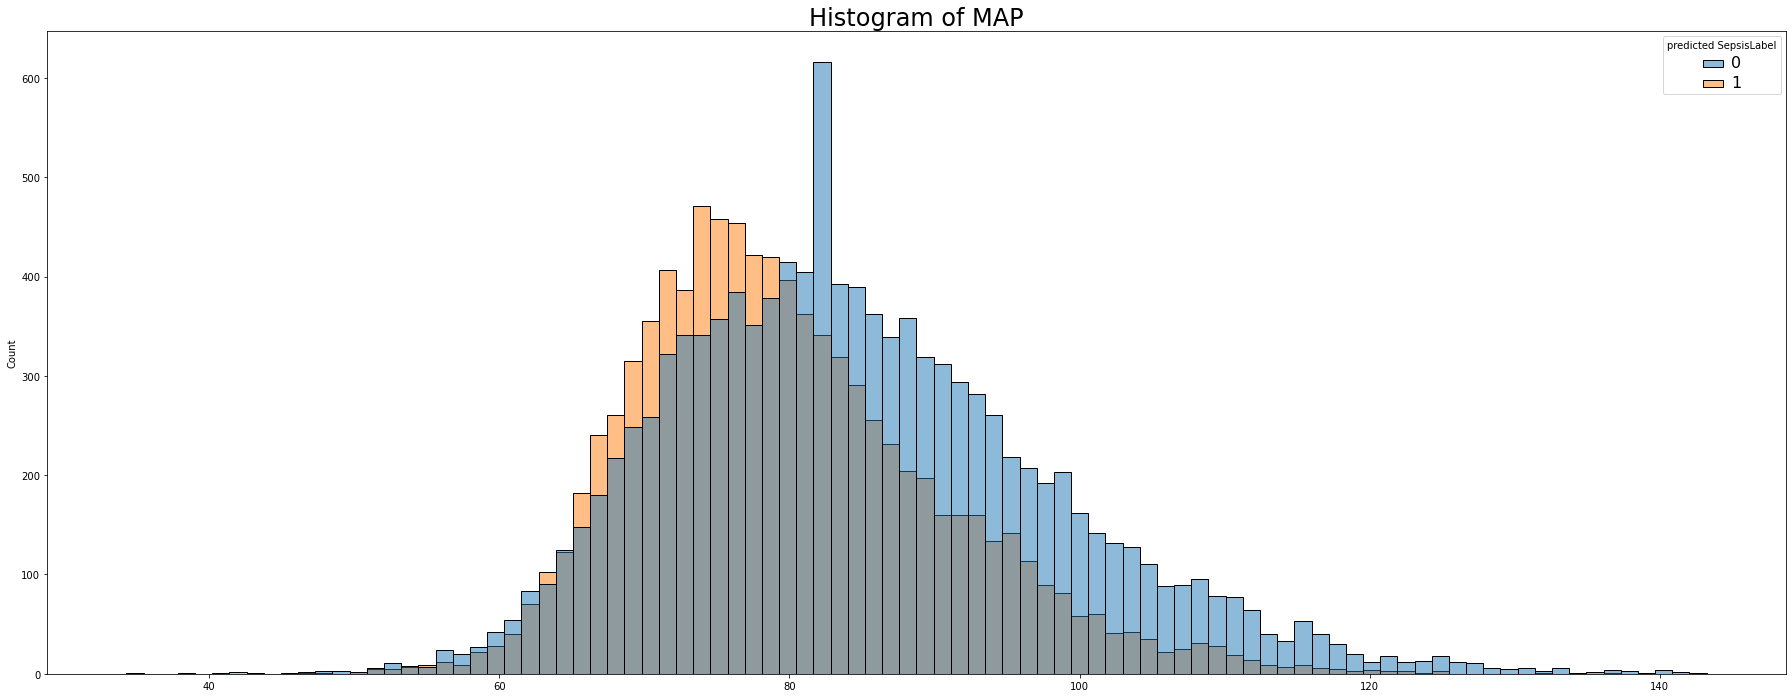

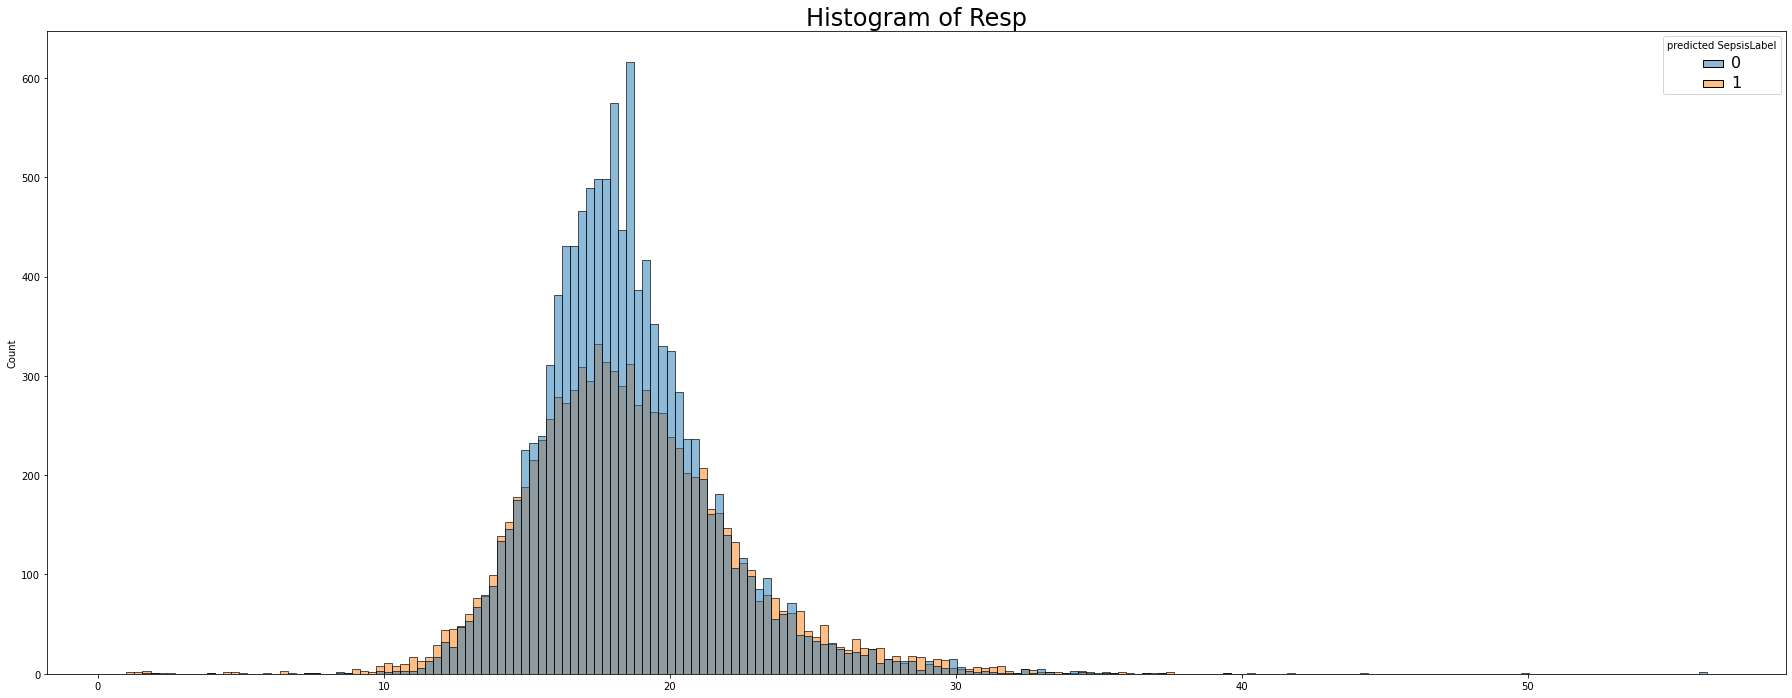

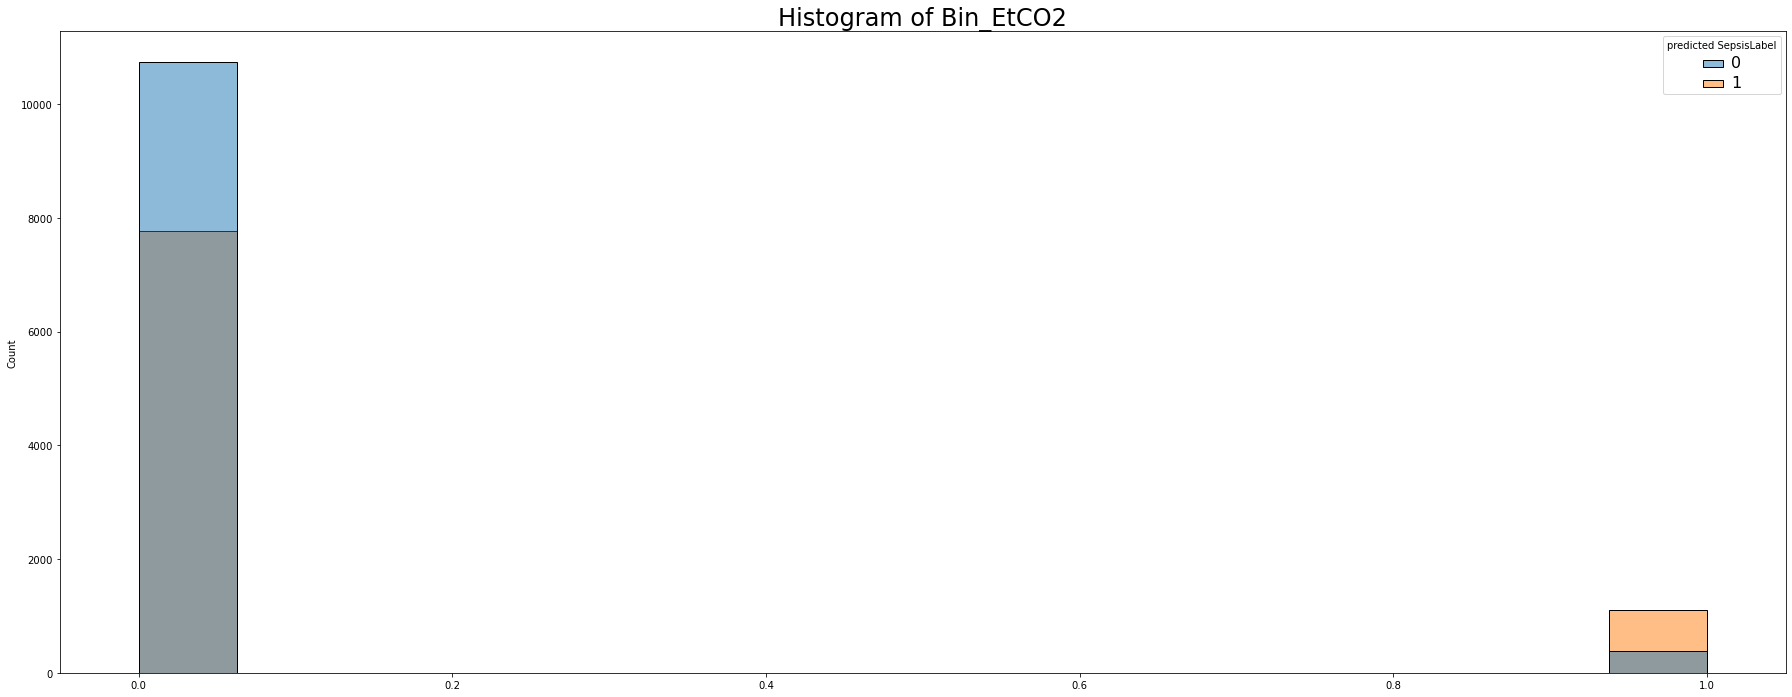

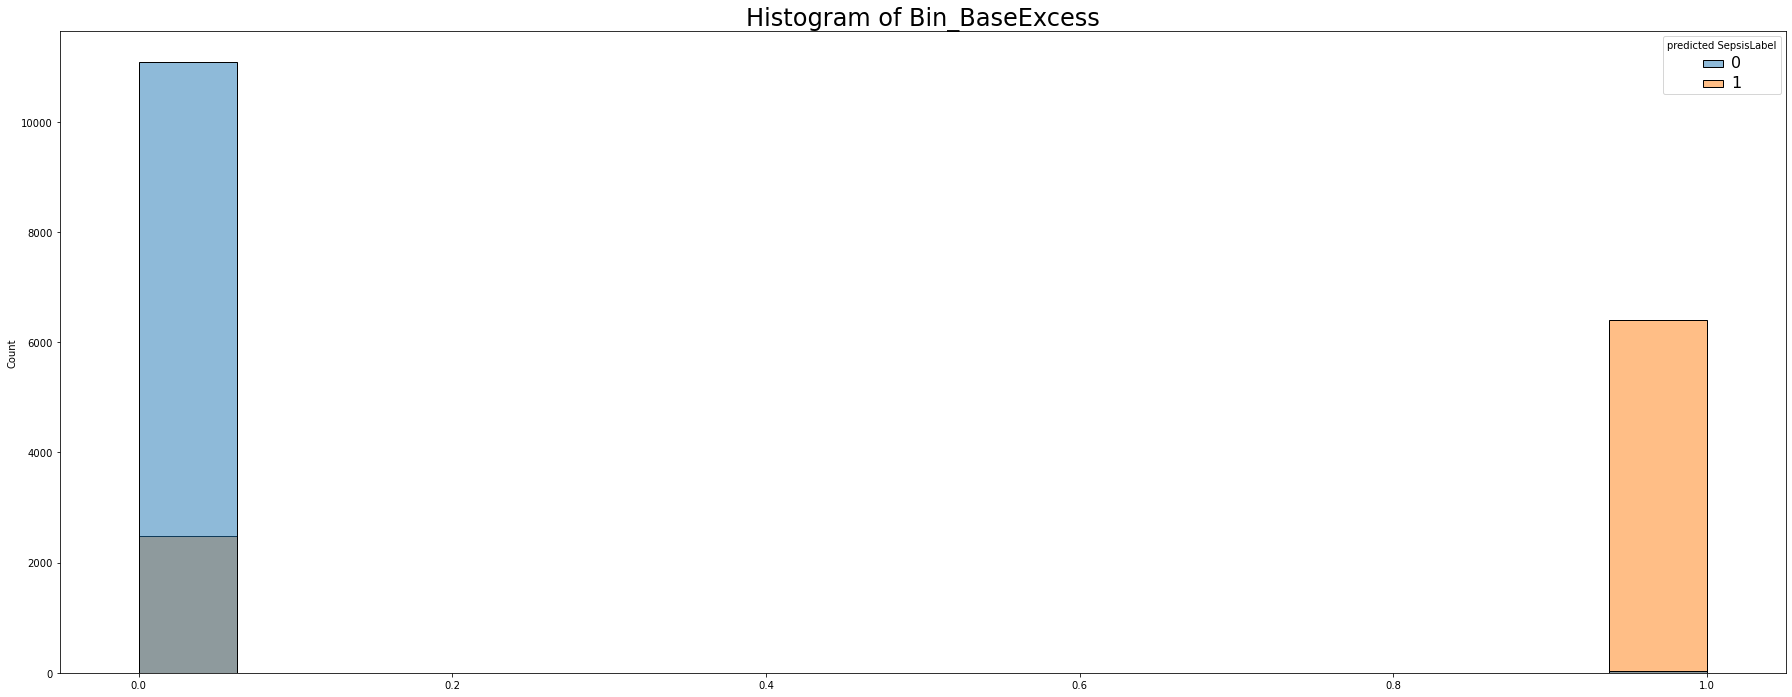

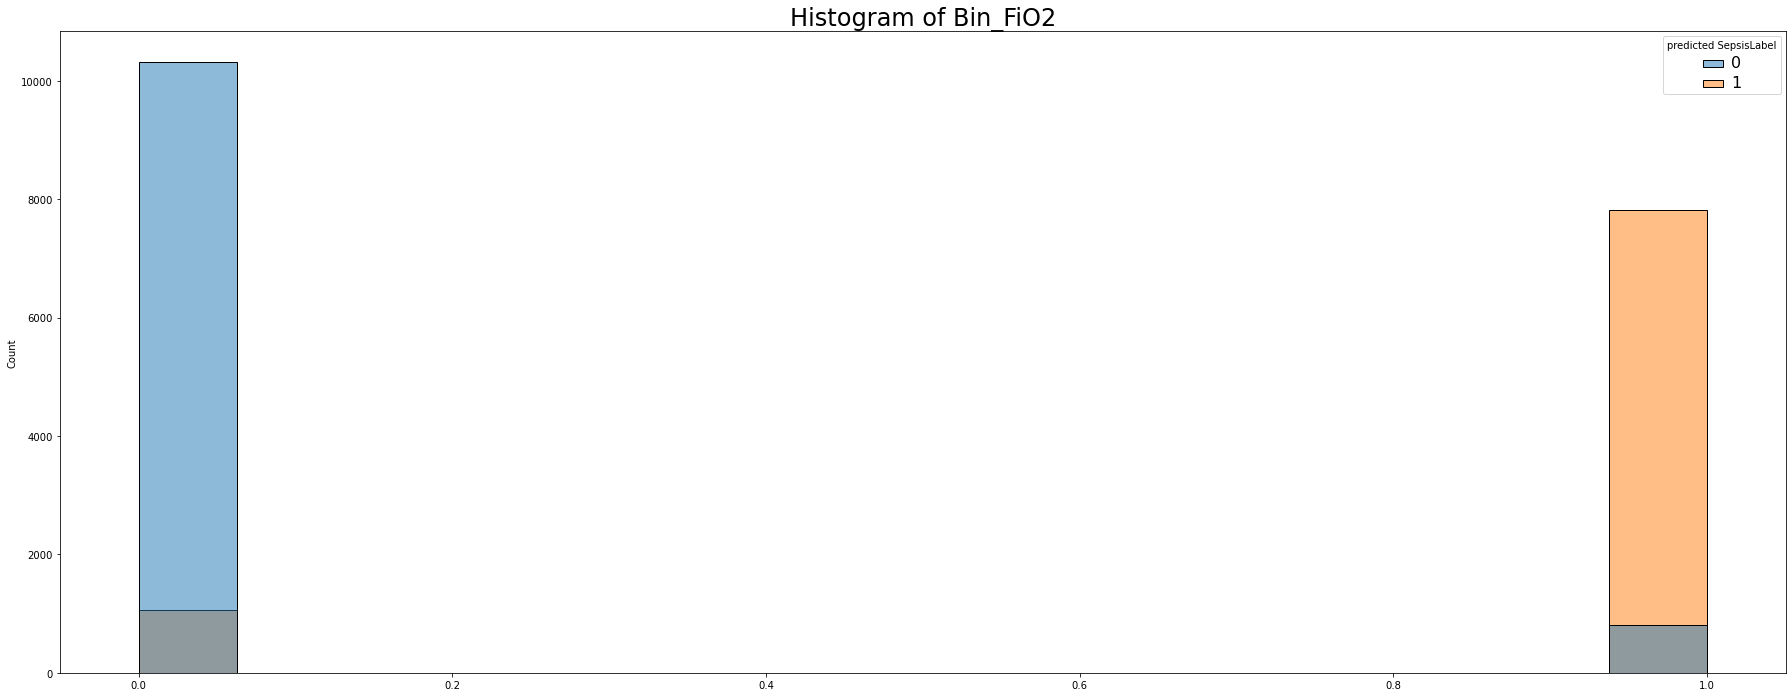

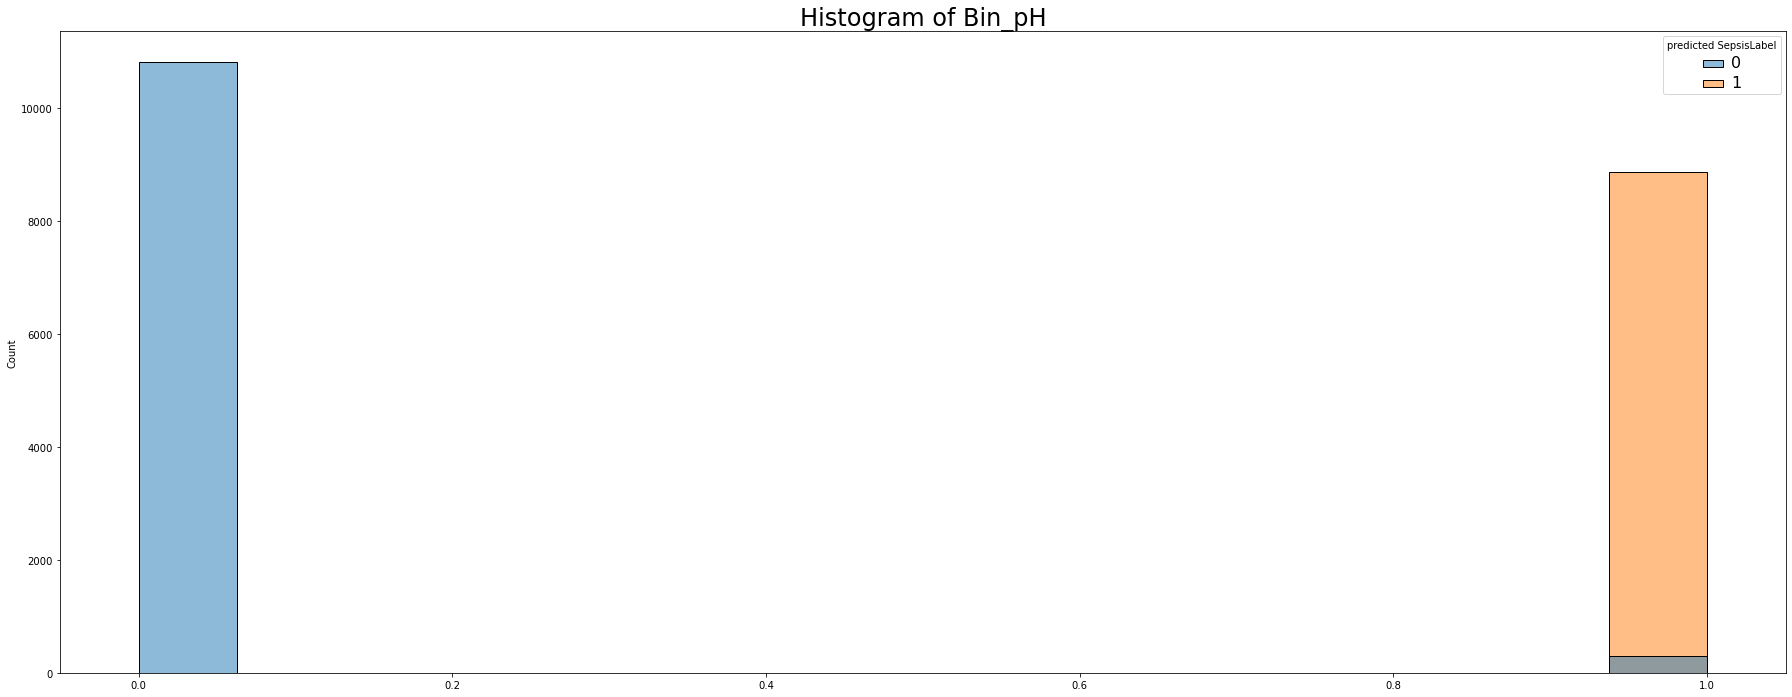

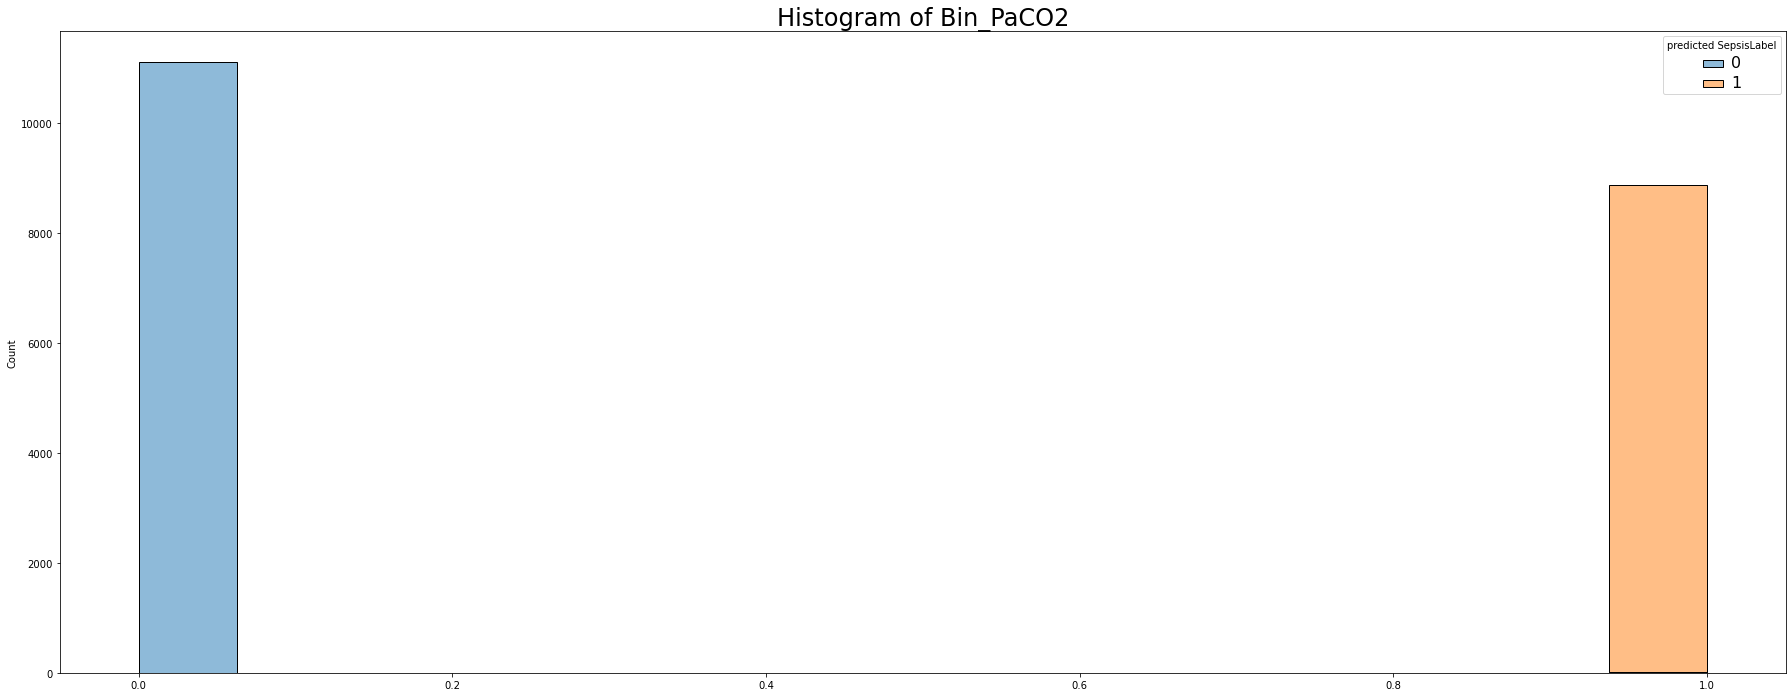

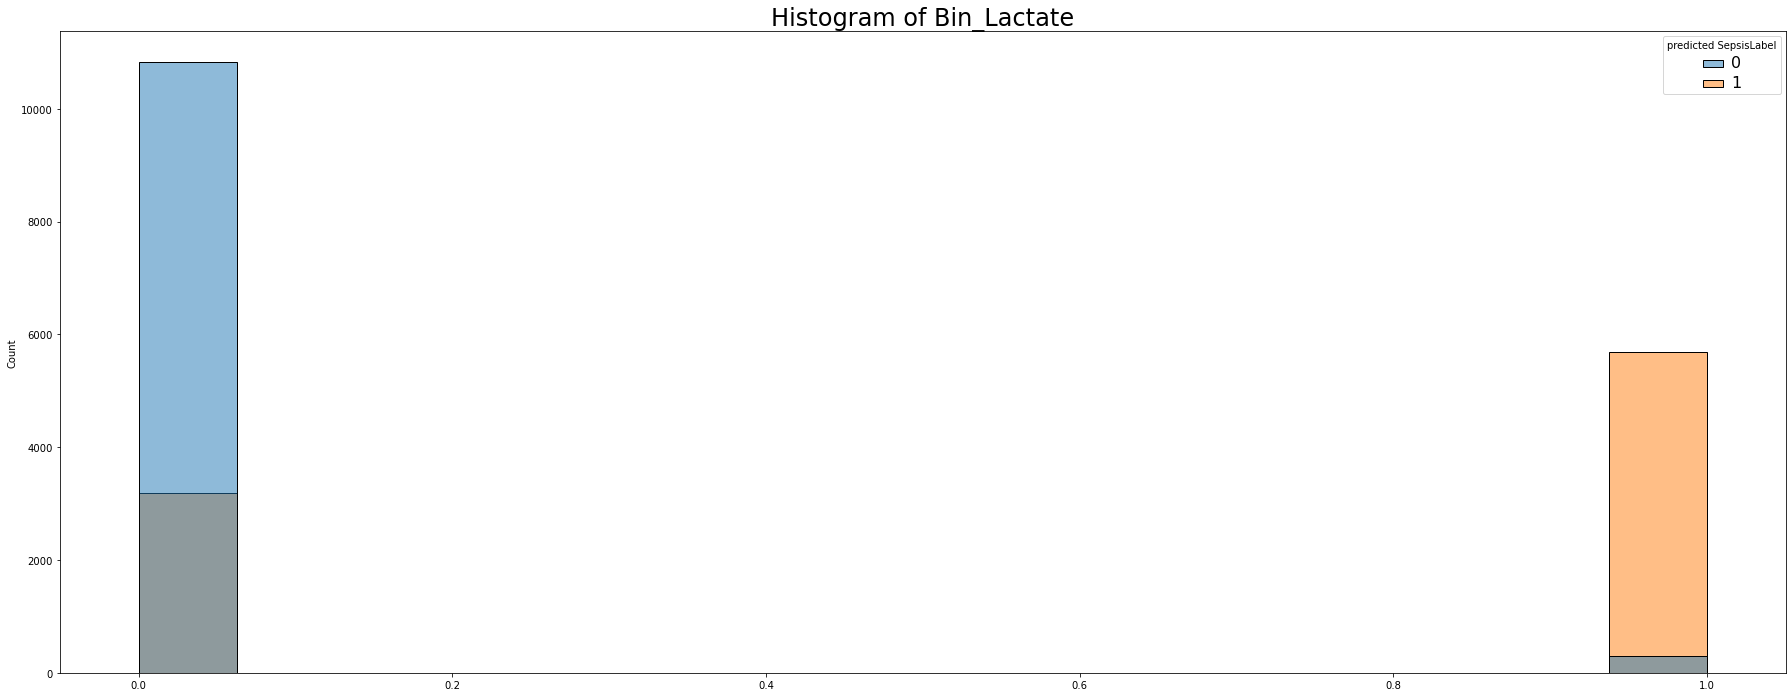

In [160]:
post_analysis(train_df_aggregated_filtered_new,xgb_cl_best)

## Algorithm 3: Randon Forest

In [189]:
rfc = RandomForestClassifier(random_state=1)

parameters= {
    'n_estimators': [100,200,500],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_features': ['auto', 'sqrt', 'log2'],
    "max_depth": [3,6,9],

}

clf_3 = GridSearchCV(xgb, parameters, n_jobs=-1, cv=2)
clf_3.fit(X_train, y_train)
clf_3.best_params_

[22:11:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "criterion", "max_features" } are not used.



{'criterion': 'gini',
 'max_depth': 3,
 'max_features': 'auto',
 'n_estimators': 100}

#### Training and validation results

In [191]:
rfc_best = RandomForestClassifier(criterion='gini',max_depth=3, max_features='auto',n_estimators=100, random_state=1)
rfc_best.fit(X_train, y_train)
predictions_3 = rfc_best.predict(X_test)
predictions_3 = np.where(predictions_3>0.5,1,0)
print("F1: ", f1_score(y_test, predictions_3))
print("Accuracy: ", accuracy_score(y_test, predictions_3))
print("Precision: ", precision_score(y_test, predictions_3))
print("Recall: ", recall_score(y_test, predictions_3))

F1:  0.367112810707457
Accuracy:  0.9448333333333333
Precision:  0.9896907216494846
Recall:  0.22535211267605634


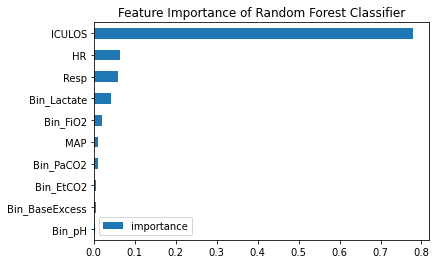

In [192]:
feature_importance_rfc = pd.DataFrame(rfc_best.feature_importances_,
                                  X_without_label.columns,
                                  columns=['importance'])
feature_importance_rfc.sort_values('importance').plot(kind='barh', title='Feature Importance of Random Forest Classifier')

#### Post analysis comparing predicted labels on each feature- RFC

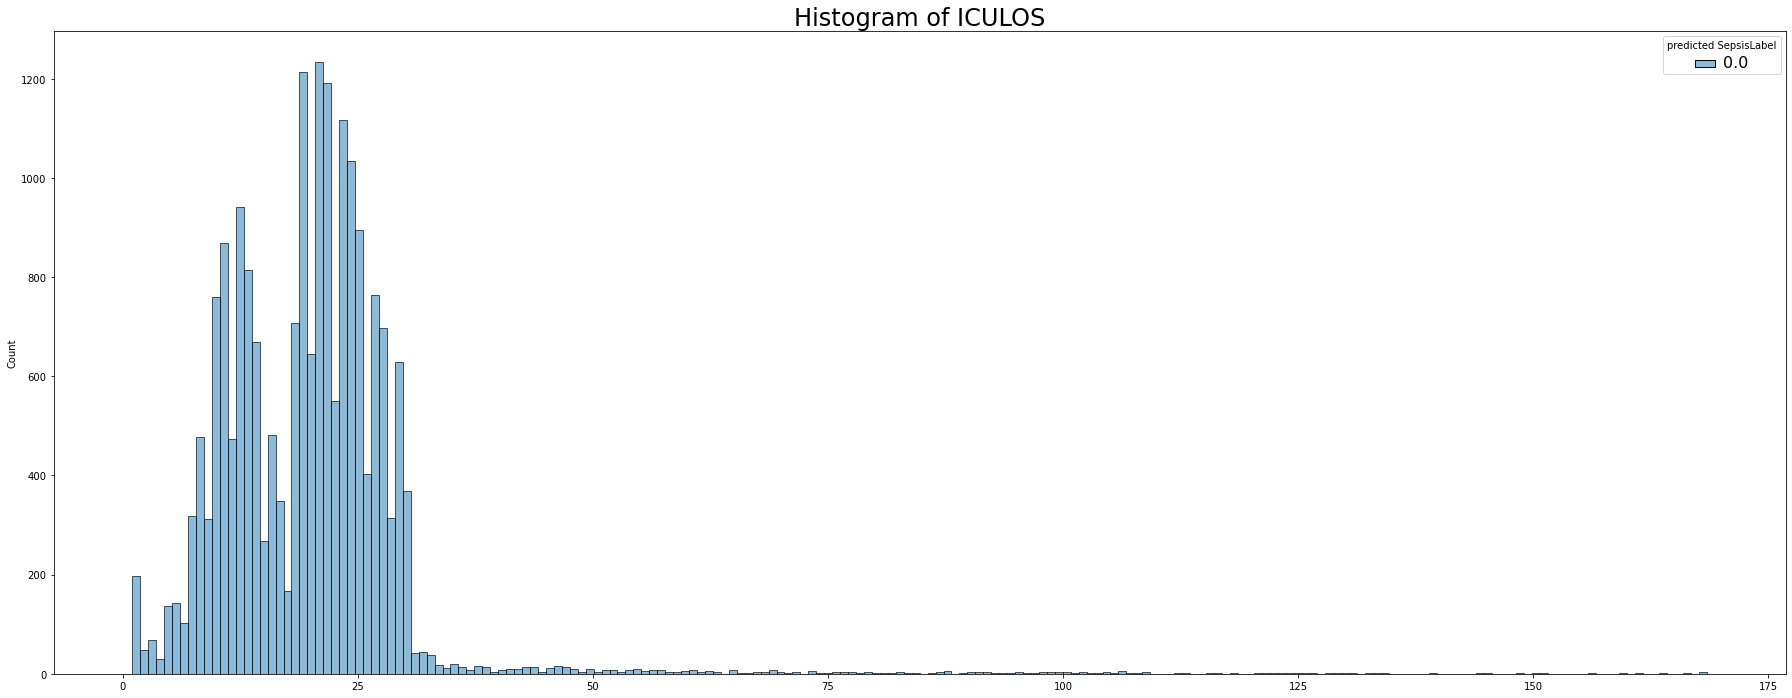

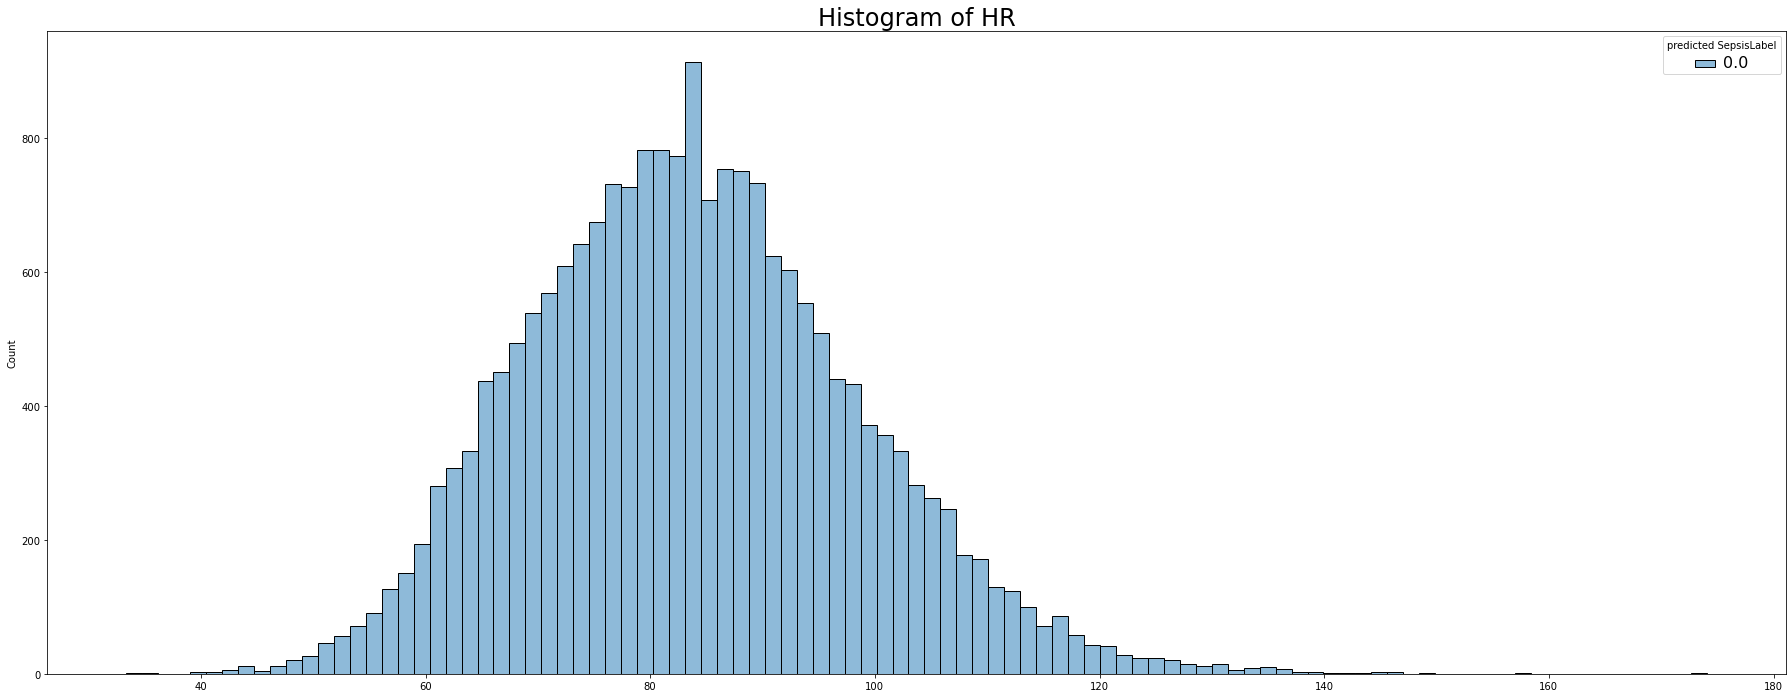

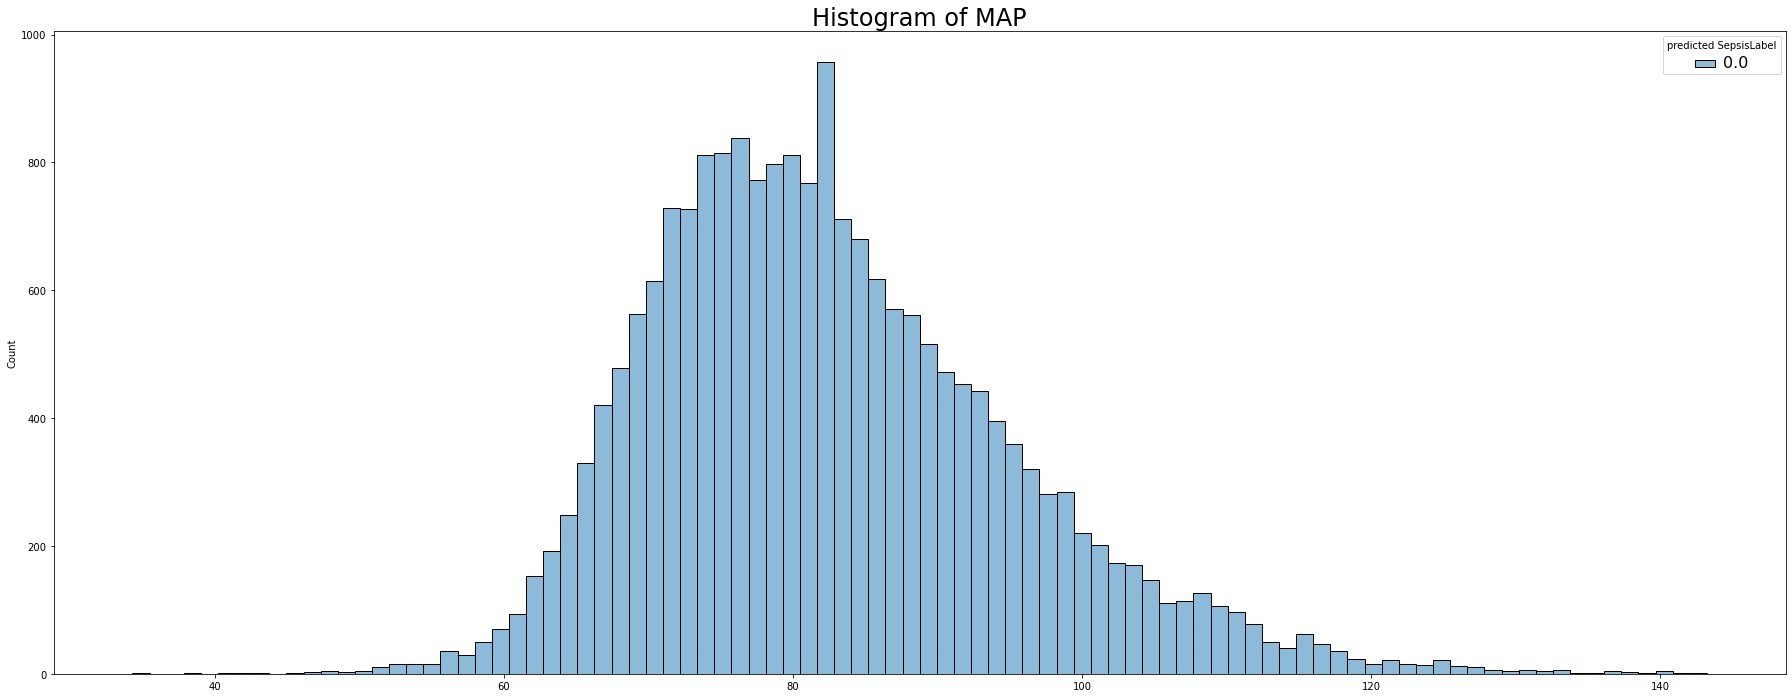

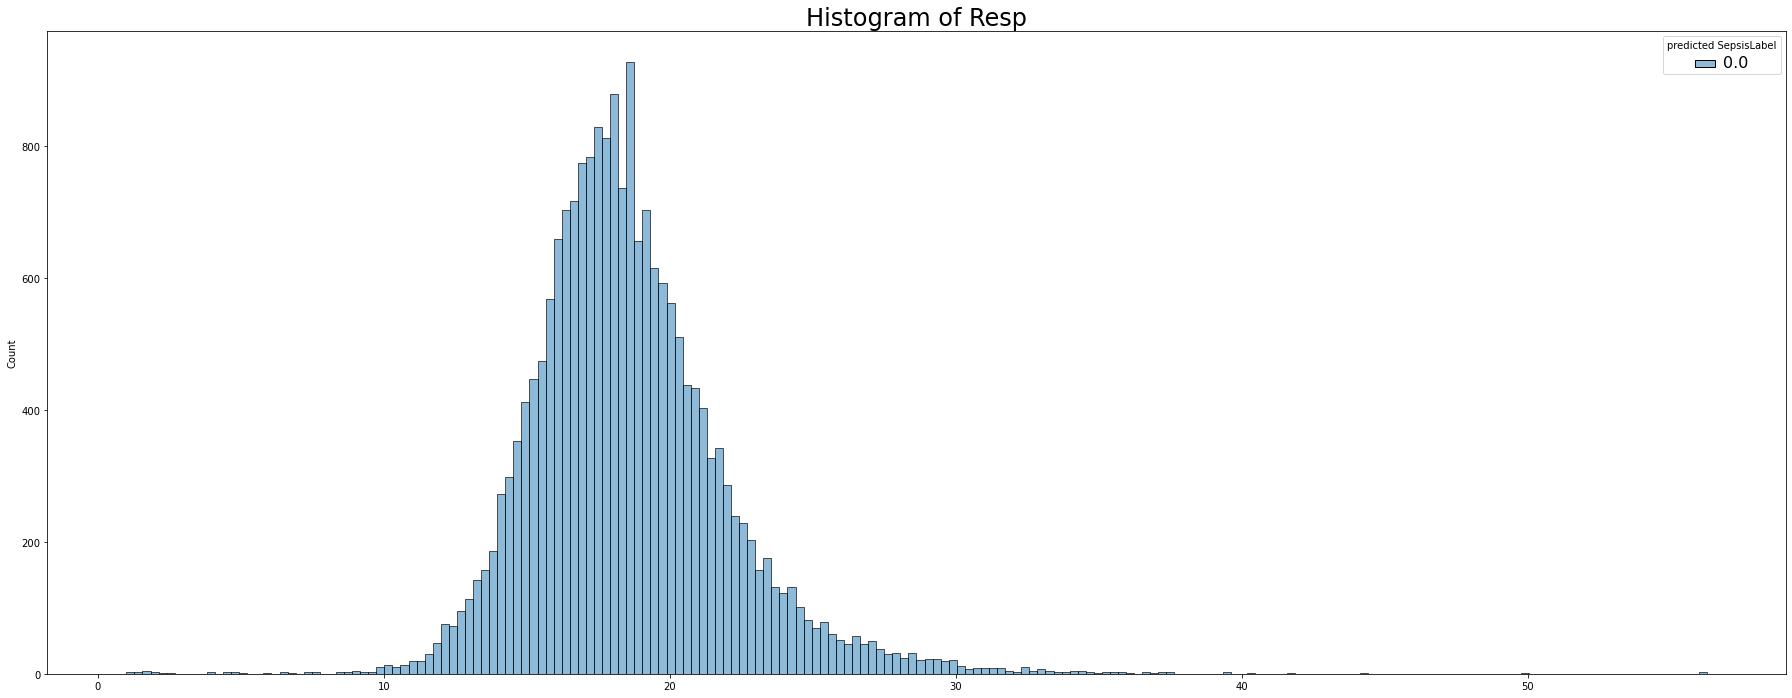

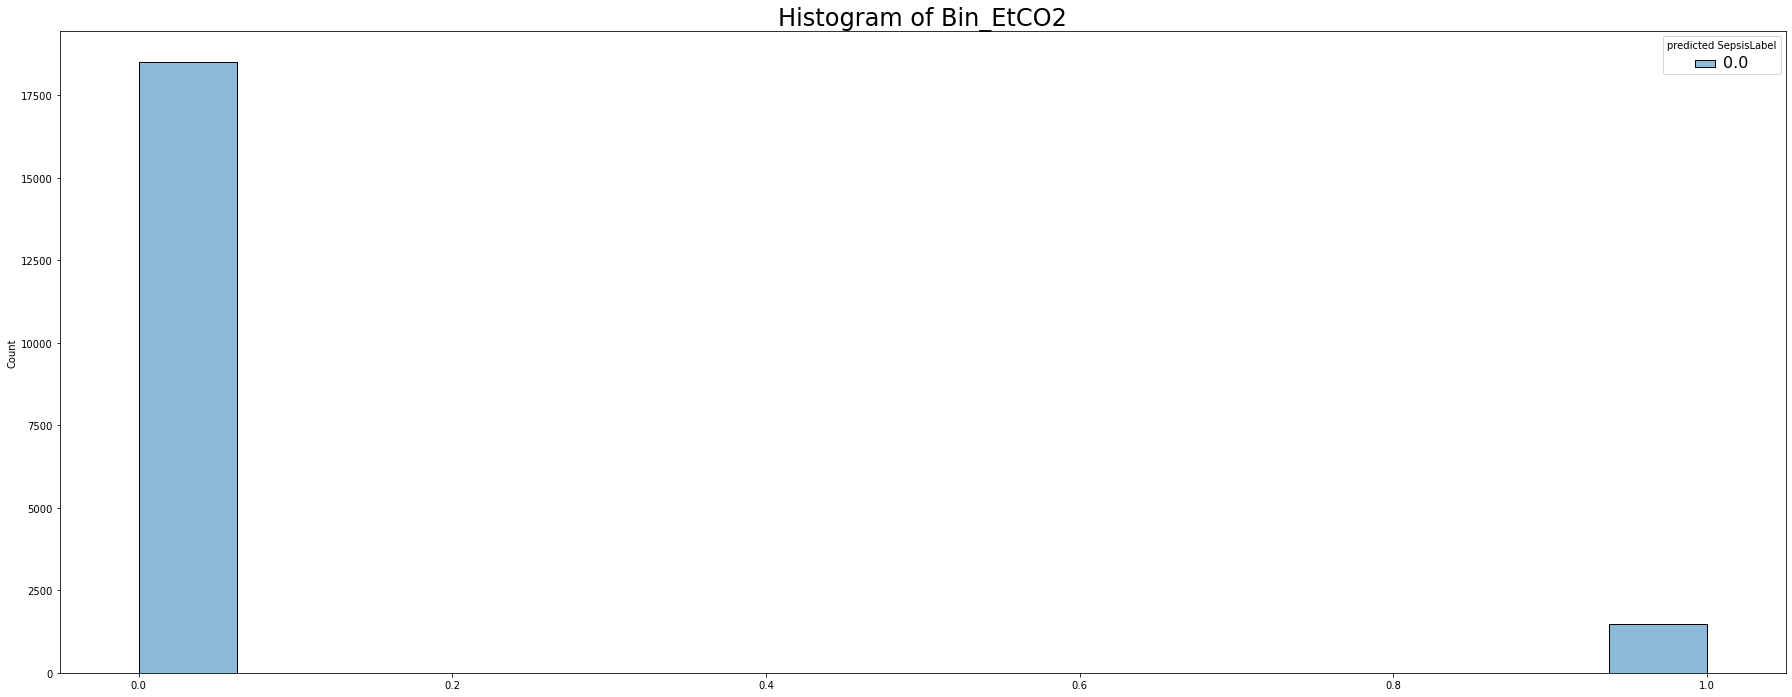

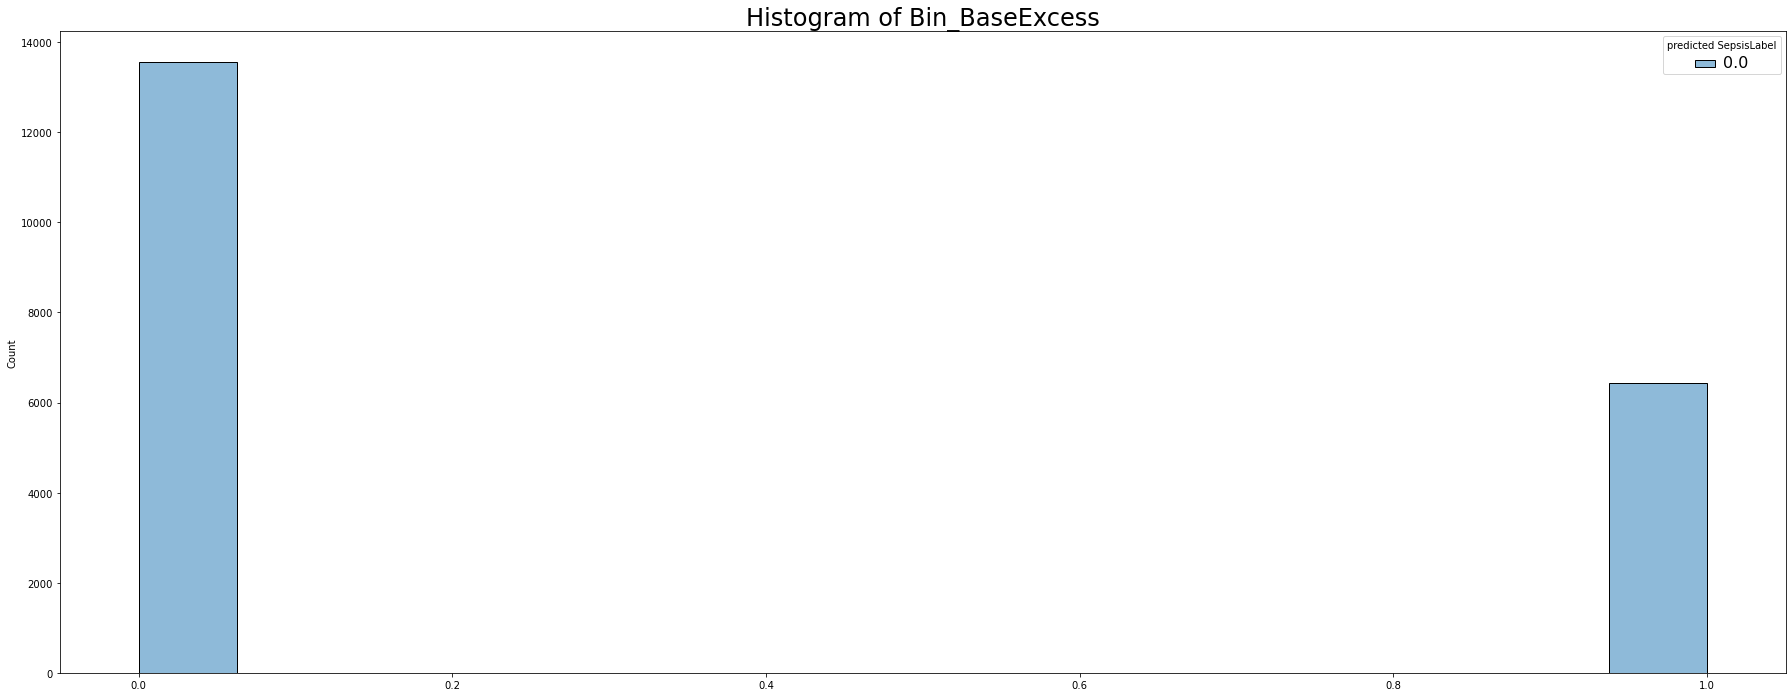

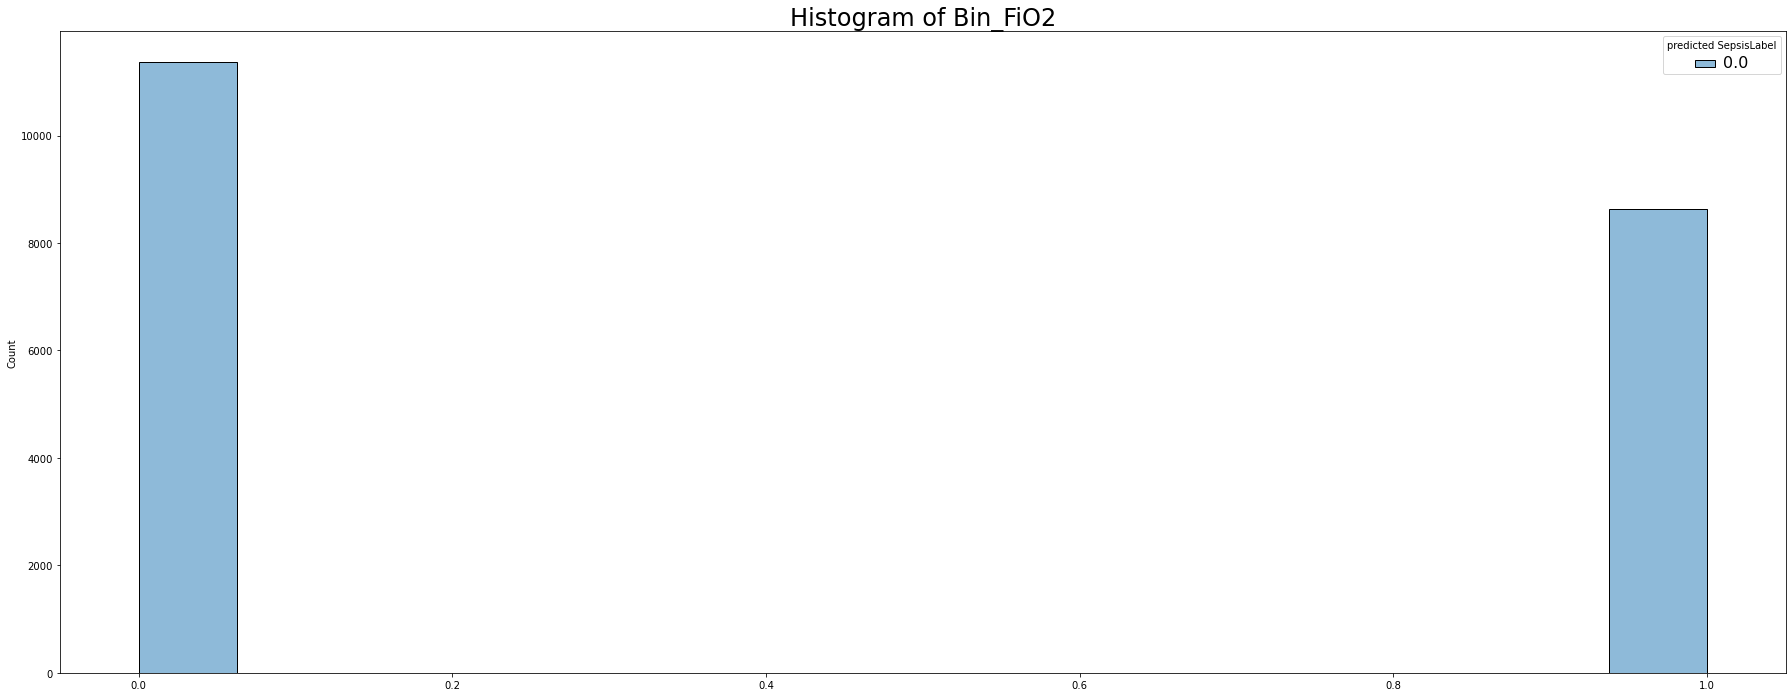

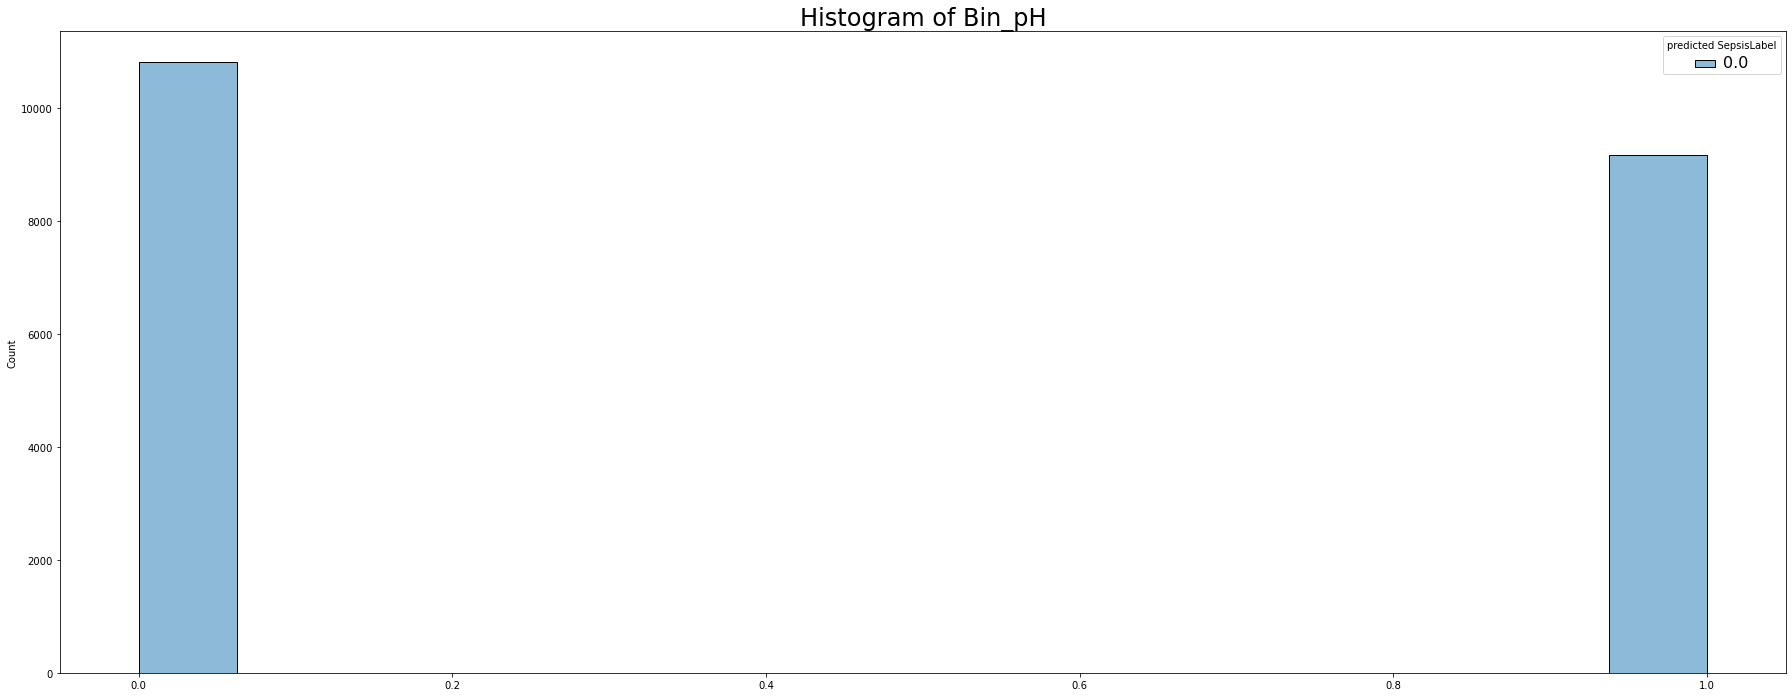

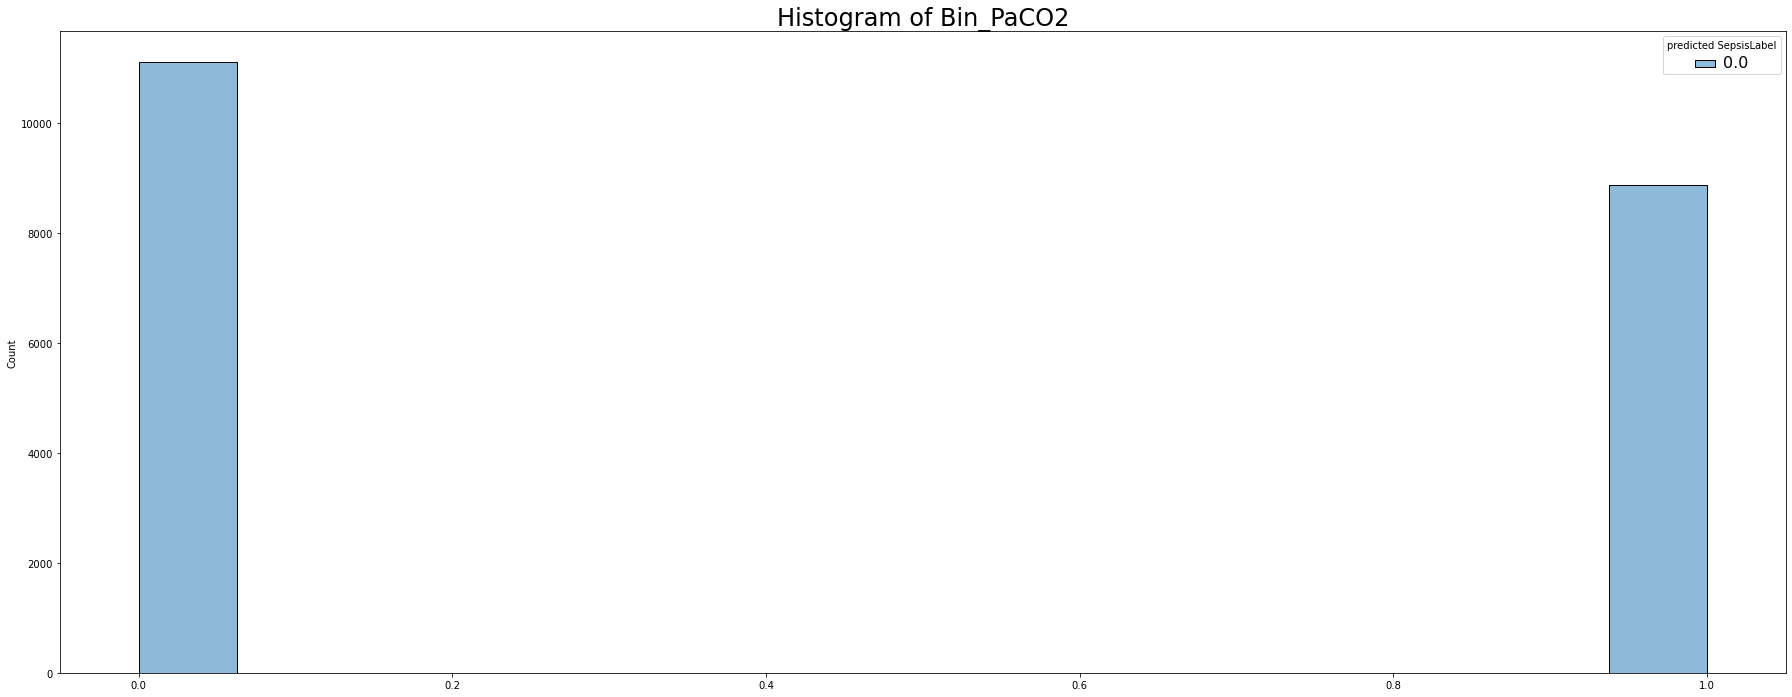

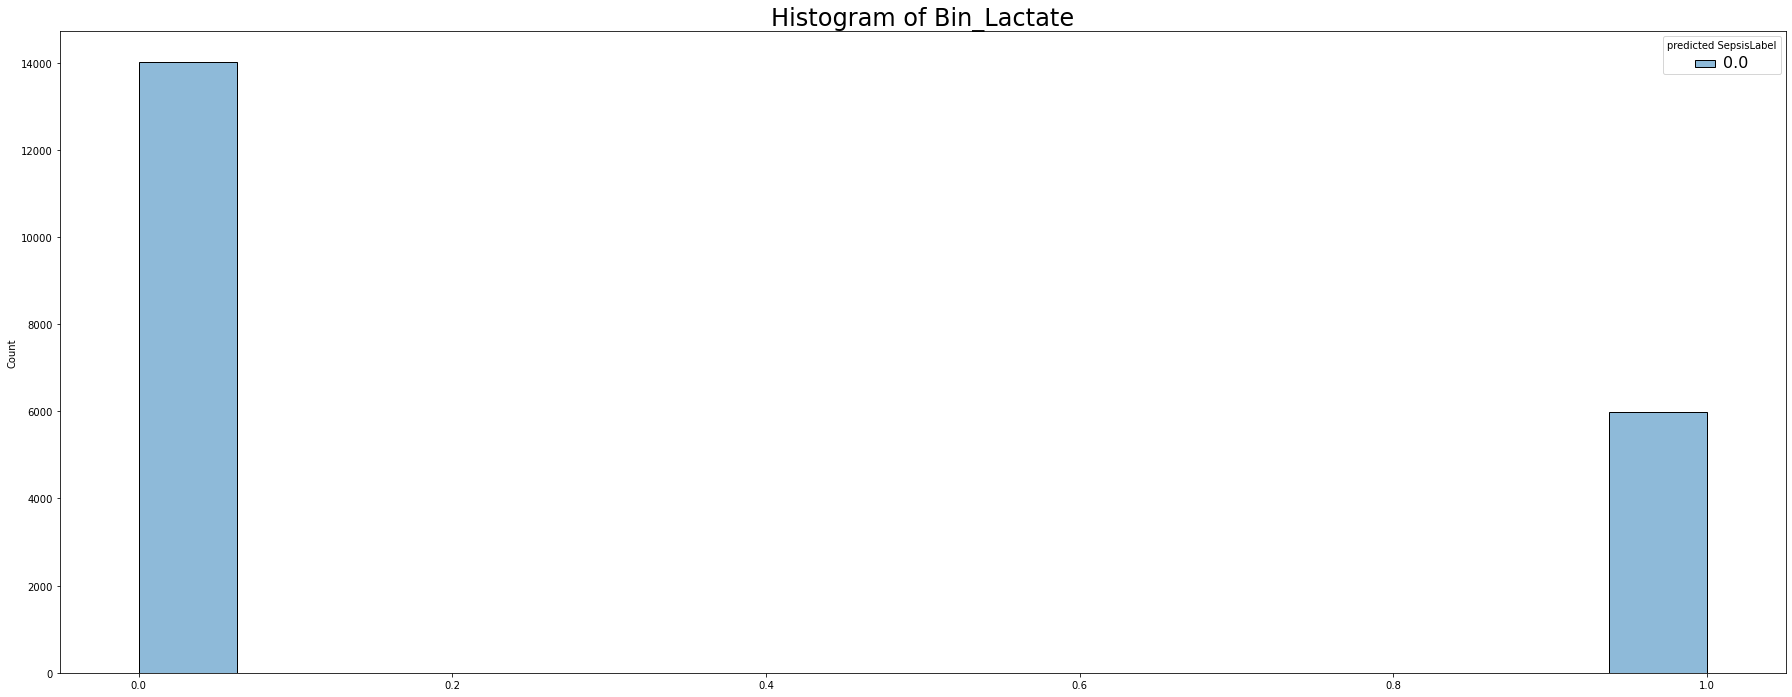

In [193]:
post_analysis(train_df_aggregated_filtered_new,rfc_best)

### Saving the best model (xgb clasifier)

In [158]:
filepath = PATH + r"/xgb_classifier_2_model.sav"
pickle.dump(xgb_best, open(filepath, 'wb'))